In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1153).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (352).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (179).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (672).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (501).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (405).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (436).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (883).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (564).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (936).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (837).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (421).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1031).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (221).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVI

## Setup

In [2]:
# Setup

import time
import os
import copy
import torch
import torchvision
import zipfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.io as io
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
from PIL import Image
import torchvision.transforms.functional as TF
import torch.optim as opt
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import itertools
from tqdm.notebook import tqdm
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Data

In [3]:
Data_Directory="../input/sarscov2-ctscan-dataset"

# Data directory and classes
data_dir="../input/sarscov2-ctscan-dataset"

print("Folders in Data set : ",os.listdir(data_dir))
classes=os.listdir(data_dir)
print("Classes : ",classes)



print("abnormal images : ",len(os.listdir(data_dir+'/COVID')))
print("normal images : ",len(os.listdir(data_dir+'/non-COVID')))

Folders in Data set :  ['non-COVID', 'COVID']
Classes :  ['non-COVID', 'COVID']
abnormal images :  1252
normal images :  1229


In [4]:
## Split into train,val,test

!pip install split-folders

In [5]:
import splitfolders
splitfolders.ratio(data_dir,output="output",seed=1337 ,ratio=(.9,.1))

Copying files: 2481 files [00:11, 217.96 files/s]


In [6]:
whole_train="./output/train"
splitfolders.ratio(whole_train,output="./output/train-val",seed=1337 ,ratio=(.9,.1))

Copying files: 2232 files [00:00, 4848.73 files/s]


In [7]:
train_ds_path="./output/train-val/train"
val_ds_path="./output/train-val/val"
test_ds_path="./output/val"
full_ds_path="./output/train"



print("train images : ",len(os.listdir(train_ds_path+'/COVID'))+len(os.listdir(train_ds_path+'/non-COVID')))
print("val images : ",len(os.listdir(val_ds_path+'/COVID'))+len(os.listdir(val_ds_path+'/non-COVID')))
print("test images : ",len(os.listdir(test_ds_path+'/COVID'))+len(os.listdir(test_ds_path+'/non-COVID')))
print("whole training images : ",len(os.listdir(full_ds_path+'/COVID'))+len(os.listdir(full_ds_path+'/non-COVID')))

print("\n")
print("abnormal train images : ",len(os.listdir(train_ds_path+'/COVID')))
print("abnormal val images : ",len(os.listdir(val_ds_path+'/COVID')))
print("abnormal test images : ",len(os.listdir(test_ds_path+'/COVID')))
print("abnormal whole training images : ",len(os.listdir(full_ds_path+'/COVID')))
print("\n")
print("normal train images : ",len(os.listdir(train_ds_path+'/non-COVID')))
print("normal val images : ",len(os.listdir(val_ds_path+'/non-COVID')))
print("normal test images : ",len(os.listdir(test_ds_path+'/non-COVID')))
print("normal whole training images : ",len(os.listdir(full_ds_path+'/non-COVID')))

train images :  2008
val images :  224
test images :  249
whole training images :  2232


abnormal train images :  1013
abnormal val images :  113
abnormal test images :  126
abnormal whole training images :  1126


normal train images :  995
normal val images :  111
normal test images :  123
normal whole training images :  1106


In [8]:
# Data transforms (normalization & data augmentation)
# Initially PIL Images
# ToTensor: convert PIL Image to tensor and values normalized 0 to 1
train_tfms = tt.Compose([
                         tt.Resize((224,224)),
                        #  tt.RandomRotation(degrees=(-20,20)),
                         tt.ToTensor()])
val_tfms = tt.Compose([
                       tt.Resize((224,224)),
                         tt.ToTensor()])
test_tfms = tt.Compose([
                        tt.Resize((224,224)),
                         tt.ToTensor()])

### Datasets

In [9]:
train_ds=ImageFolder(train_ds_path, transform=train_tfms)
val_ds=ImageFolder(val_ds_path, transform=val_tfms)
test_ds=ImageFolder(test_ds_path, transform=test_tfms)
full_ds=ImageFolder(full_ds_path, transform=train_tfms)
# test_dataset=test_ds

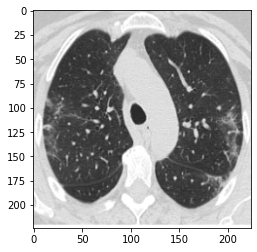

In [10]:
for img,label in train_ds:
  img=img.squeeze_()
  img=img.permute(1,2,0)
  plt.imshow(img,cmap="gray")
  break

### Data Loader

In [11]:
batch_size = 20
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)
# test_dataloader=test_dl

## Model

### GPU

In [12]:
### GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### Plotting

In [13]:
def plot_confusion_matrix(data_loader,nb_classes):
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    y_pred=[]
    y_true=[]
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(val_dl):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            outs=preds.detach().cpu().numpy()
            classess=classes.detach().cpu().numpy()
            y_pred=np.concatenate((y_pred,outs),axis=None)
            y_true=np.concatenate((y_true,classess),axis=None)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    array=confusion_matrix(y_pred,y_true)
    classes=os.listdir(data_dir)
    df_cm = pd.DataFrame(array, index =classes,
                  columns = classes)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

### Squeezenet

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item(),dtype=torch.float32)


class ImageClassificationBase(nn.Module):
    def training_step(self,batch, loss_func):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = loss_func(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch,loss_func):
        images, labels = batch
        out = self(images)                    # Generate predictions
        # print("out : ",out)
        # print("labels : ",labels)
        loss = loss_func(out, labels)   # Calculate loss
        crct_pred = accuracy(out, labels)           # Calculate accuracy
        # print("crct_pred ",crct_pred," batch_size : ",20)
        return {'val_loss': loss.detach(), 'crct_pred': crct_pred, 'batch_size' : len(images)}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_sizes=[x['batch_size'] for x in outputs]
        net_size=sum(batch_sizes)
        crct_preds = [x['crct_pred'] for x in outputs]
        epoch_acc = sum(crct_preds)/net_size
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))
    def pred(self,img):
      out=self(img)
      return out
    def predictions(self,images):
      outputs=self(images)
      _, preds = torch.max(outputs, dim=1)
      return preds


In [15]:
@torch.no_grad()
def evaluate(model, val_loader,loss_func):
    model.eval()
    outputs = [model.validation_step(batch,loss_func) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader,loss_func, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch,loss_func)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader,loss_func)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None,loss_func=F.cross_entropy, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up cosine annealing lr learning rate scheduler
    count=0
    for batch in tqdm(train_loader):
      count=count+1
    num_iter=count*epochs
    sched=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_iter,
                                                     eta_min=0.00001)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch,loss_func)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader,loss_func)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

#### With Freezing

In [18]:
class SQUEEZENET(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network =models.squeezenet1_0(pretrained=pretrained)
        # Freeze model weights
        for param in self.network.parameters():
          param.requires_grad = False
        # Replace last layer
        self.network.classifier[1]= nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        for param in self.network.classifier.parameters():
          param.requires_grad = True
          
    def forward(self, xb):
        return self.network(xb)

##### Cross Entropy

In [19]:
# Parameters
num_classes=2
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss_func=F.cross_entropy

# Model
model=SQUEEZENET(num_classes)
to_device(model,device)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


  0%|          | 0.00/4.79M [00:00<?, ?B/s]

SQUEEZENET(
  (network): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (exp

In [20]:
torch.manual_seed(42)
k=5
num_epochs = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [21]:
def train_epoch(model,device,dataloader,scheduler,loss_fn=F.cross_entropy,optimizer=torch.optim.Adam,grad_clip=0):

    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        if grad_clip:
          nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,num_classes,device,dataloader,loss_fn=F.cross_entropy,grad_clip=0):
  valid_loss, val_correct = 0.0, 0
  y_true=[]
  y_pred=[]
  model.eval()
  for images, labels in dataloader:

      images,labels = images.to(device),labels.to(device)
      output = model(images)
      loss=loss_fn(output,labels)
      valid_loss+=loss.item()*images.size(0)
      scores, predictions = torch.max(output.data,1)
      val_correct+=(predictions == labels).sum().item()
      predictions=predictions.detach().cpu().tolist()
      labels=labels.detach().cpu().tolist()
      y_pred.extend(predictions)
      y_true.extend(labels)

  array=confusion_matrix(y_pred,y_true)
  classes=os.listdir(data_dir)
  df_cm = pd.DataFrame(array, index =classes,
                  columns = classes)
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')
  plt.show()
  
  return valid_loss,val_correct

def cross_validate(model,num_classes,full_ds,opt_func,loss_func,grad_clip):
  foldperf={}
  for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(full_ds)))):

      print('Fold {}'.format(fold + 1))

      train_sampler = SubsetRandomSampler(train_idx)
      test_sampler = SubsetRandomSampler(val_idx)
      train_loader = DataLoader(full_ds, batch_size=batch_size, sampler=train_sampler)
      test_loader = DataLoader(full_ds, batch_size=batch_size, sampler=test_sampler)
    
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
      model.to(device)
      print(loss_func)
      optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
      # Set up cosine annealing lr learning rate scheduler
      count=0
      for batch in tqdm(train_loader):
        count=count+1
      num_iter=count*num_epochs
      sched=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_iter,
                                                     eta_min=0.00001)

      history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

      for epoch in range(num_epochs):
          train_loss, train_correct=train_epoch(model,device,train_loader,sched,loss_func,optimizer,grad_clip)
          test_loss, test_correct=valid_epoch(model,num_classes,device,test_loader,loss_func,grad_clip)

          train_loss = train_loss / len(train_loader.sampler)
          train_acc = train_correct / len(train_loader.sampler) * 100
          test_loss = test_loss / len(test_loader.sampler)
          test_acc = test_correct / len(test_loader.sampler) * 100

          print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
          history['train_loss'].append(train_loss)
          history['test_loss'].append(test_loss)
          history['train_acc'].append(train_acc)
          history['test_acc'].append(test_acc)
      
      foldperf['fold{}'.format(fold+1)] = history  

  torch.save(model,'k_cross_CNN.pt')
  return foldperf


def test(model,device,dataloader,test_dataset,loss_fn):
  test_loss, test_correct = 0.0, 0
  model.eval()
  y_true=[]
  y_pred=[]
  for images, labels in dataloader:

      images,labels = images.to(device),labels.to(device)
      output = model(images)
      loss=loss_fn(output,labels)
      test_loss+=loss.item()*images.size(0)
      scores, predictions = torch.max(output.data,1)
      test_correct+=(predictions == labels).sum().item()
      predictions=predictions.detach().cpu().tolist()
      labels=labels.detach().cpu().tolist()
      y_pred.extend(predictions)
      y_true.extend(labels)
    
  test_loss = test_loss / len(test_dataset)
  test_acc = test_correct / len(test_dataset) * 100
  array=confusion_matrix(y_pred,y_true)
  classes=os.listdir(data_dir)
  df_cm = pd.DataFrame(array, index =classes,
                  columns = classes)
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')
  plt.show()

  return test_loss,test_acc

  test_loss = test_loss / len(test_dataset)
  test_acc = test_correct / len(test_dataset) * 100


def cv_results(foldperf):
  testl_f,tl_f,testa_f,ta_f=[],[],[],[]
  testl_fm,tl_fm,testa_fm,ta_fm=[],[],[],[]
  for f in range(1,k+1):

      tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
      testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

      ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
      testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))
      tl_fm.append(np.max(foldperf['fold{}'.format(f)]['train_loss']))
      testl_fm.append(np.max(foldperf['fold{}'.format(f)]['test_loss']))

      ta_fm.append(np.max(foldperf['fold{}'.format(f)]['train_acc']))
      testa_fm.append(np.max(foldperf['fold{}'.format(f)]['test_acc']))

  print('Performance of {} fold cross validation'.format(k))
  print("Average Training Loss: {:.3f} \t Average val Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average val Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))  
  print("Max Training Acc: {:.2f} \t Max val Acc: {:.2f}".format(np.max(ta_fm),np.max(testa_fm)))  

Fold 1
<function cross_entropy at 0x7f44f18c0f80>


  0%|          | 0/90 [00:00<?, ?it/s]

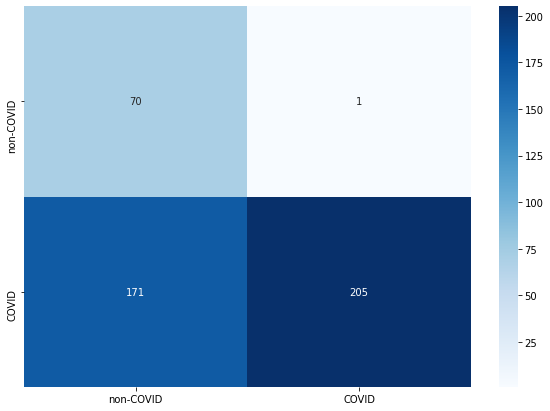

Epoch:1/10 AVG Training Loss:0.751 AVG Test Loss:0.776 AVG Training Acc 67.96 % AVG Test Acc 61.52 %


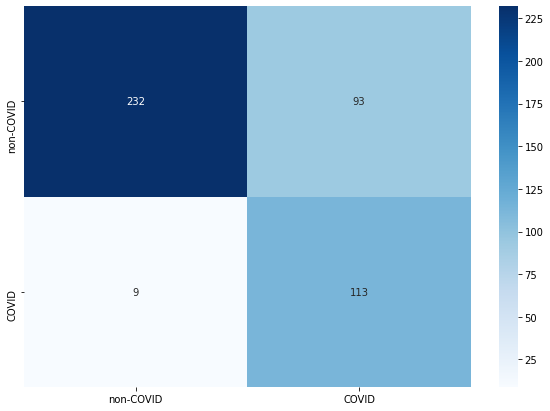

Epoch:2/10 AVG Training Loss:0.591 AVG Test Loss:0.484 AVG Training Acc 75.41 % AVG Test Acc 77.18 %


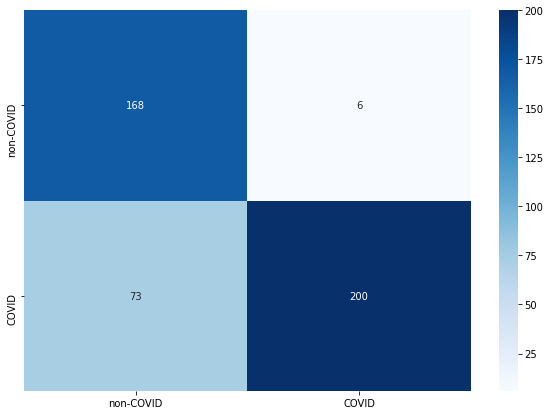

Epoch:3/10 AVG Training Loss:0.351 AVG Test Loss:0.404 AVG Training Acc 84.48 % AVG Test Acc 82.33 %


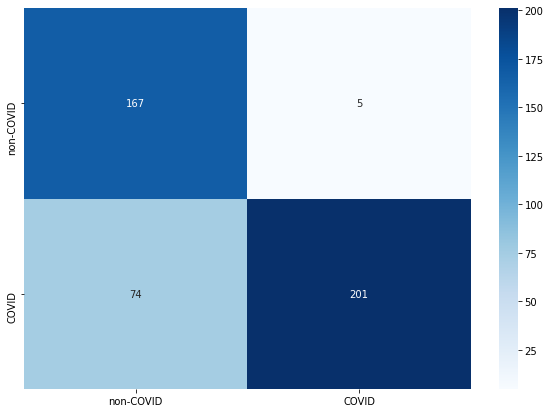

Epoch:4/10 AVG Training Loss:0.308 AVG Test Loss:0.423 AVG Training Acc 87.34 % AVG Test Acc 82.33 %


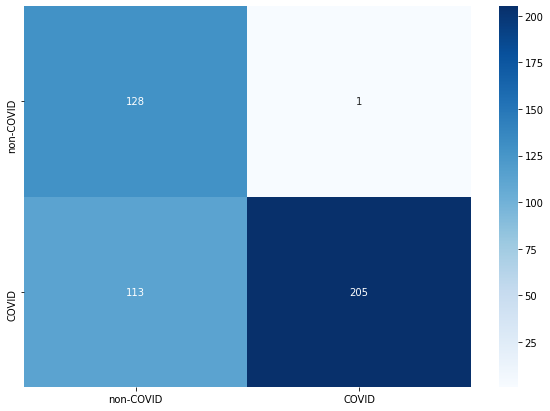

Epoch:5/10 AVG Training Loss:0.317 AVG Test Loss:0.652 AVG Training Acc 86.61 % AVG Test Acc 74.50 %


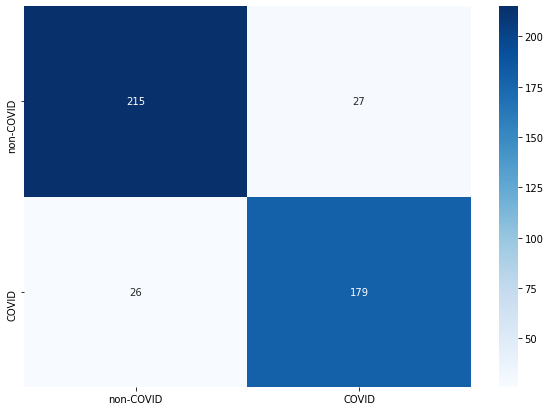

Epoch:6/10 AVG Training Loss:0.381 AVG Test Loss:0.279 AVG Training Acc 84.37 % AVG Test Acc 88.14 %


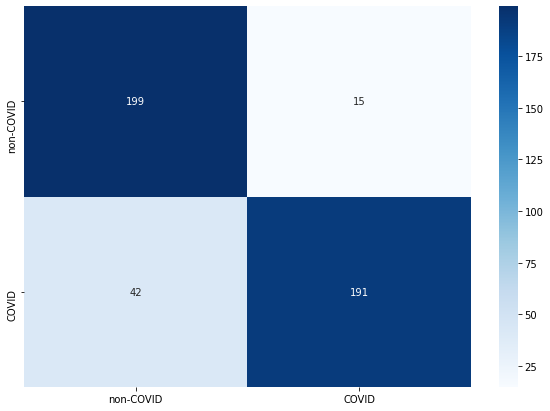

Epoch:7/10 AVG Training Loss:0.264 AVG Test Loss:0.313 AVG Training Acc 89.47 % AVG Test Acc 87.25 %


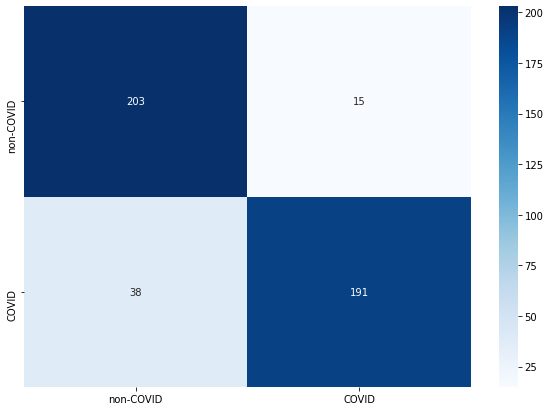

Epoch:8/10 AVG Training Loss:0.252 AVG Test Loss:0.292 AVG Training Acc 89.47 % AVG Test Acc 88.14 %


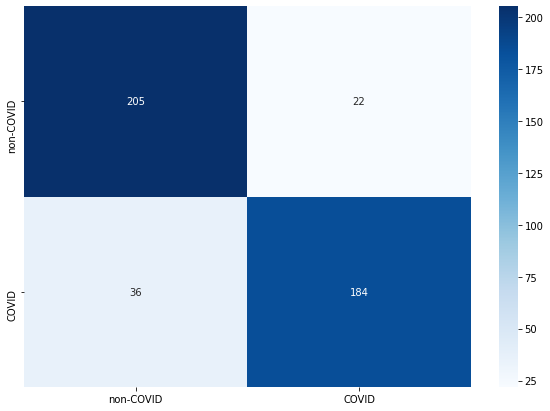

Epoch:9/10 AVG Training Loss:0.218 AVG Test Loss:0.271 AVG Training Acc 90.48 % AVG Test Acc 87.02 %


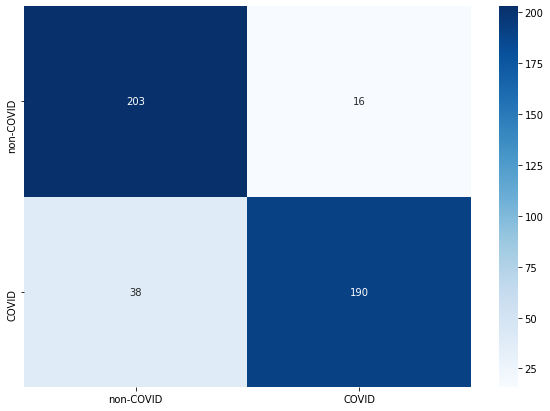

Epoch:10/10 AVG Training Loss:0.215 AVG Test Loss:0.285 AVG Training Acc 90.92 % AVG Test Acc 87.92 %
Fold 2
<function cross_entropy at 0x7f44f18c0f80>


  0%|          | 0/90 [00:00<?, ?it/s]

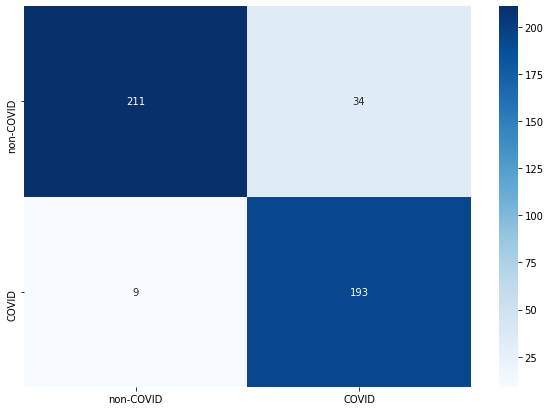

Epoch:1/10 AVG Training Loss:0.407 AVG Test Loss:0.233 AVG Training Acc 84.76 % AVG Test Acc 90.38 %


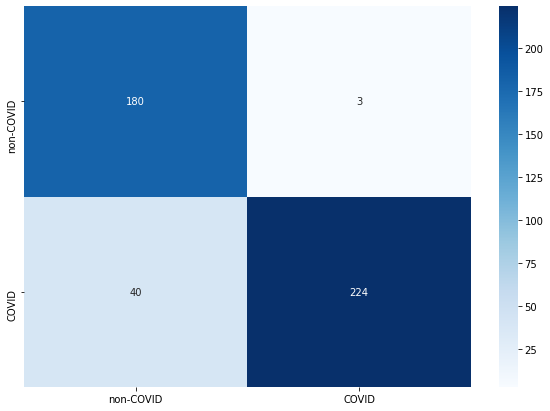

Epoch:2/10 AVG Training Loss:0.315 AVG Test Loss:0.234 AVG Training Acc 86.61 % AVG Test Acc 90.38 %


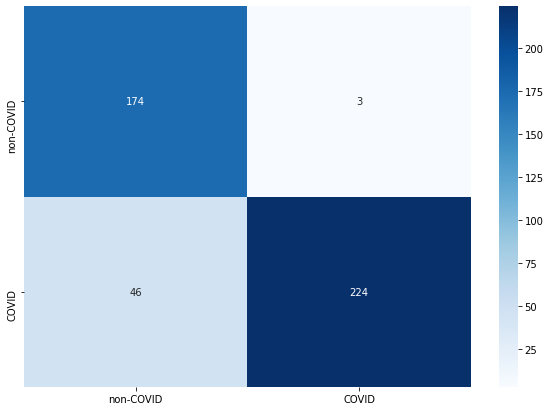

Epoch:3/10 AVG Training Loss:0.348 AVG Test Loss:0.264 AVG Training Acc 85.43 % AVG Test Acc 89.04 %


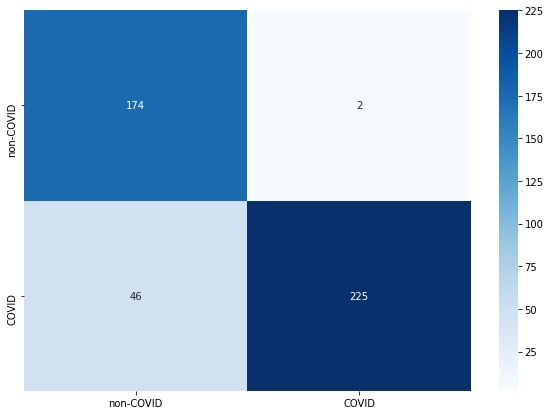

Epoch:4/10 AVG Training Loss:0.300 AVG Test Loss:0.253 AVG Training Acc 88.18 % AVG Test Acc 89.26 %


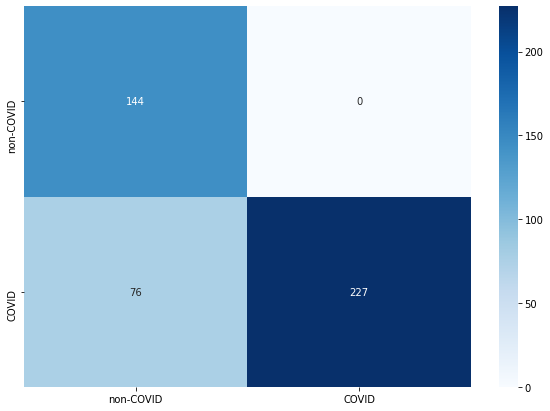

Epoch:5/10 AVG Training Loss:0.338 AVG Test Loss:0.456 AVG Training Acc 86.11 % AVG Test Acc 83.00 %


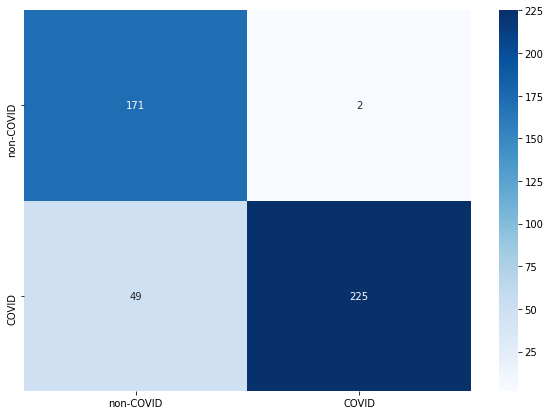

Epoch:6/10 AVG Training Loss:0.271 AVG Test Loss:0.275 AVG Training Acc 88.63 % AVG Test Acc 88.59 %


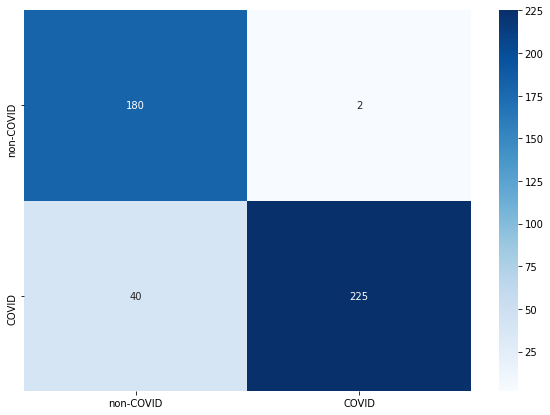

Epoch:7/10 AVG Training Loss:0.238 AVG Test Loss:0.231 AVG Training Acc 89.47 % AVG Test Acc 90.60 %


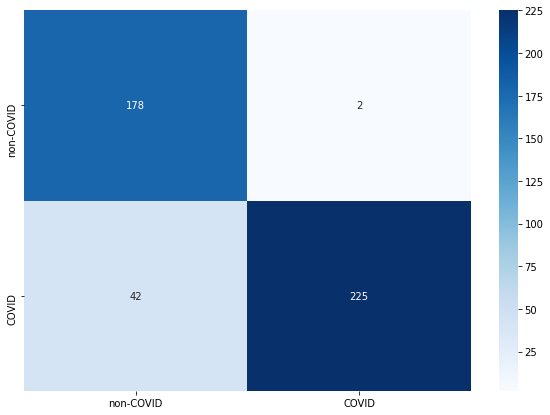

Epoch:8/10 AVG Training Loss:0.226 AVG Test Loss:0.239 AVG Training Acc 91.09 % AVG Test Acc 90.16 %


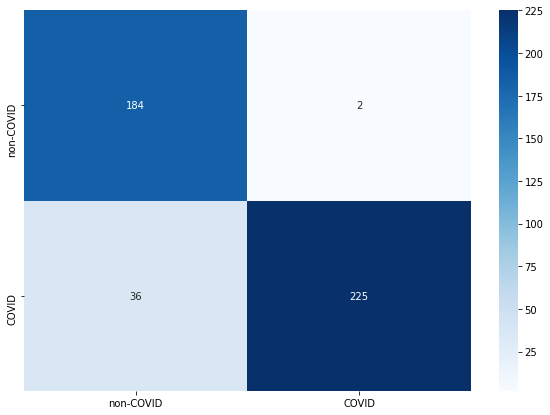

Epoch:9/10 AVG Training Loss:0.237 AVG Test Loss:0.218 AVG Training Acc 90.03 % AVG Test Acc 91.50 %


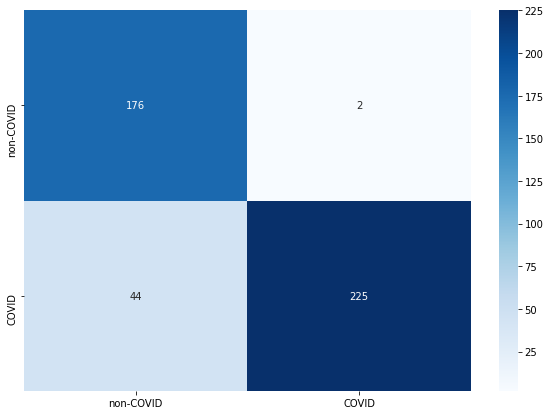

Epoch:10/10 AVG Training Loss:0.215 AVG Test Loss:0.246 AVG Training Acc 90.76 % AVG Test Acc 89.71 %
Fold 3
<function cross_entropy at 0x7f44f18c0f80>


  0%|          | 0/90 [00:00<?, ?it/s]

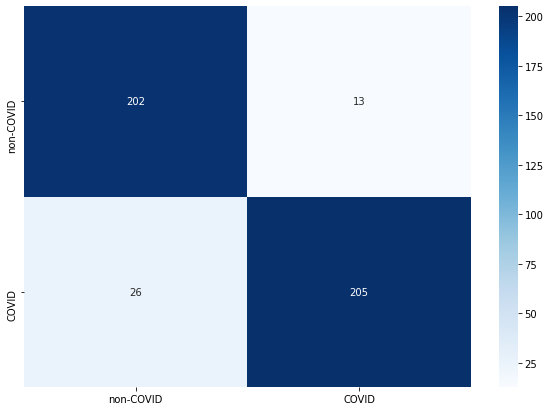

Epoch:1/10 AVG Training Loss:0.344 AVG Test Loss:0.197 AVG Training Acc 86.67 % AVG Test Acc 91.26 %


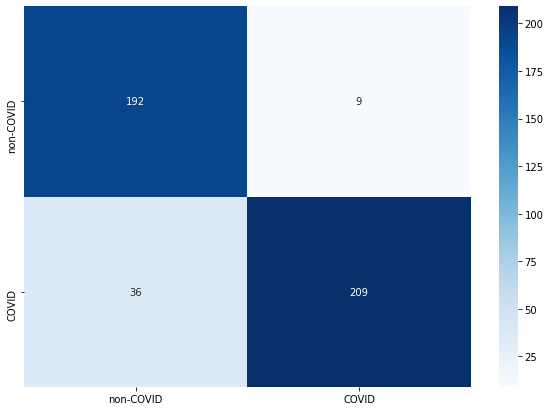

Epoch:2/10 AVG Training Loss:0.297 AVG Test Loss:0.247 AVG Training Acc 89.08 % AVG Test Acc 89.91 %


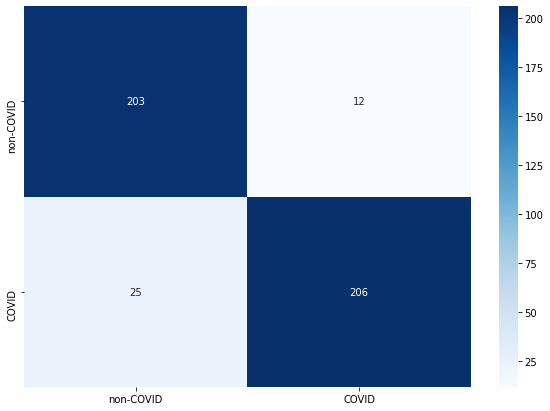

Epoch:3/10 AVG Training Loss:0.277 AVG Test Loss:0.208 AVG Training Acc 88.80 % AVG Test Acc 91.70 %


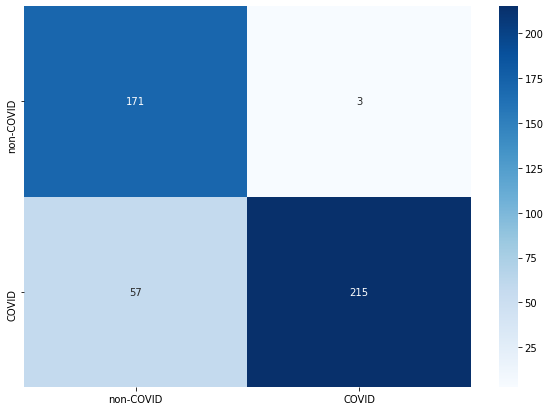

Epoch:4/10 AVG Training Loss:0.279 AVG Test Loss:0.319 AVG Training Acc 88.86 % AVG Test Acc 86.55 %


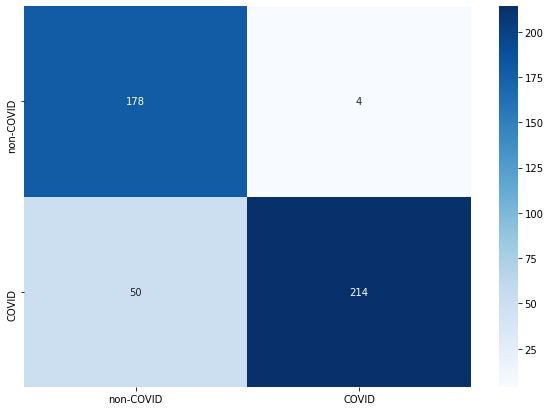

Epoch:5/10 AVG Training Loss:0.253 AVG Test Loss:0.294 AVG Training Acc 88.91 % AVG Test Acc 87.89 %


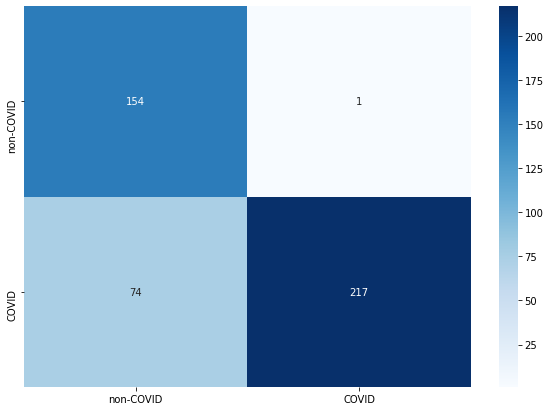

Epoch:6/10 AVG Training Loss:0.237 AVG Test Loss:0.389 AVG Training Acc 89.87 % AVG Test Acc 83.18 %


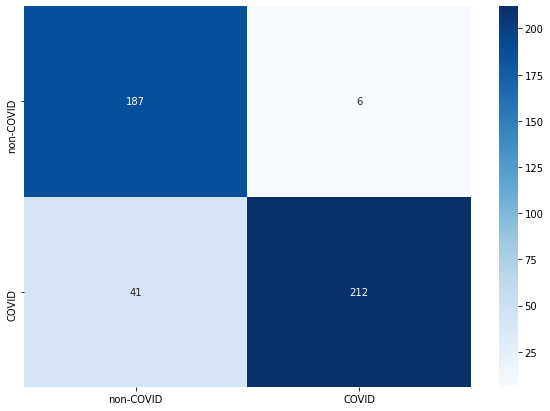

Epoch:7/10 AVG Training Loss:0.230 AVG Test Loss:0.246 AVG Training Acc 90.87 % AVG Test Acc 89.46 %


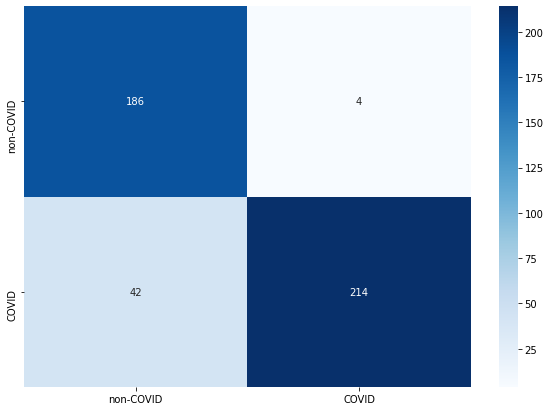

Epoch:8/10 AVG Training Loss:0.200 AVG Test Loss:0.269 AVG Training Acc 91.71 % AVG Test Acc 89.69 %


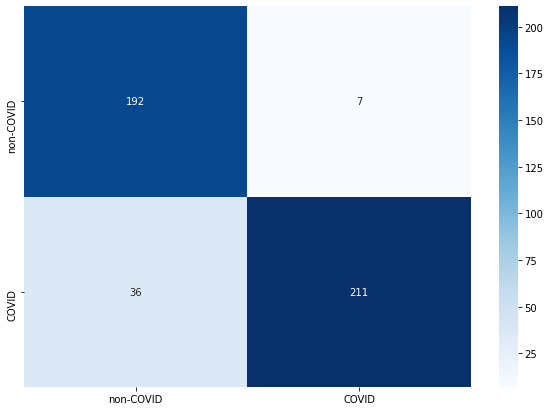

Epoch:9/10 AVG Training Loss:0.202 AVG Test Loss:0.229 AVG Training Acc 92.11 % AVG Test Acc 90.36 %


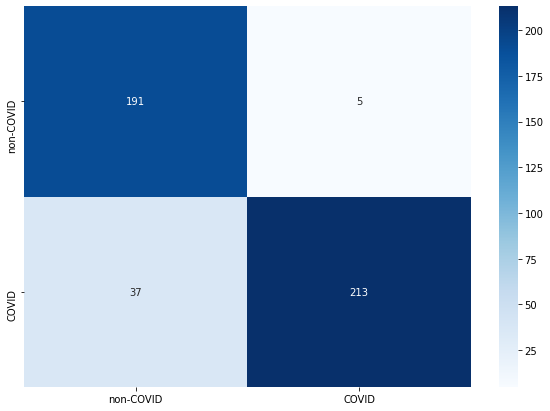

Epoch:10/10 AVG Training Loss:0.191 AVG Test Loss:0.236 AVG Training Acc 91.99 % AVG Test Acc 90.58 %
Fold 4
<function cross_entropy at 0x7f44f18c0f80>


  0%|          | 0/90 [00:00<?, ?it/s]

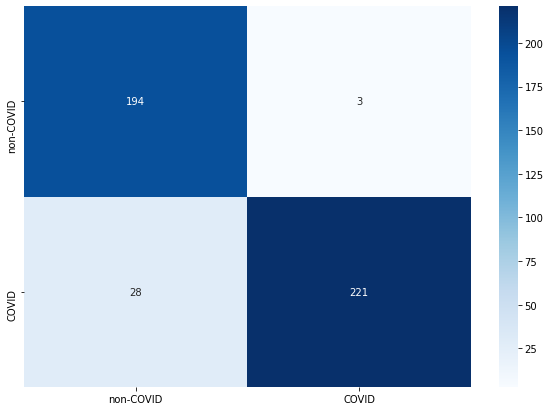

Epoch:1/10 AVG Training Loss:0.287 AVG Test Loss:0.173 AVG Training Acc 88.75 % AVG Test Acc 93.05 %


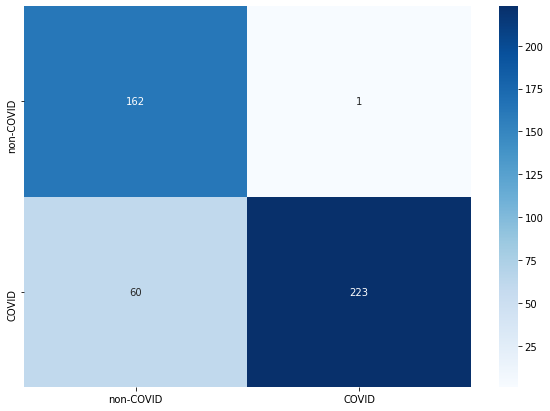

Epoch:2/10 AVG Training Loss:0.313 AVG Test Loss:0.265 AVG Training Acc 88.69 % AVG Test Acc 86.32 %


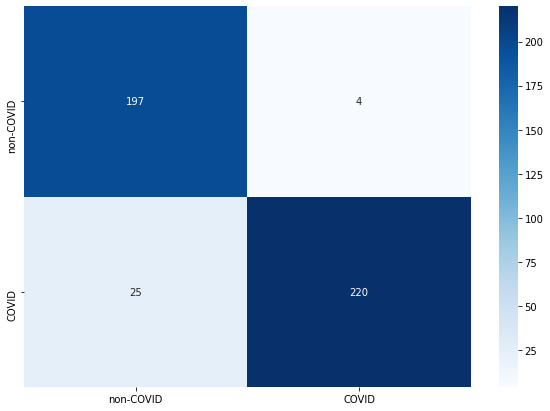

Epoch:3/10 AVG Training Loss:0.286 AVG Test Loss:0.155 AVG Training Acc 88.24 % AVG Test Acc 93.50 %


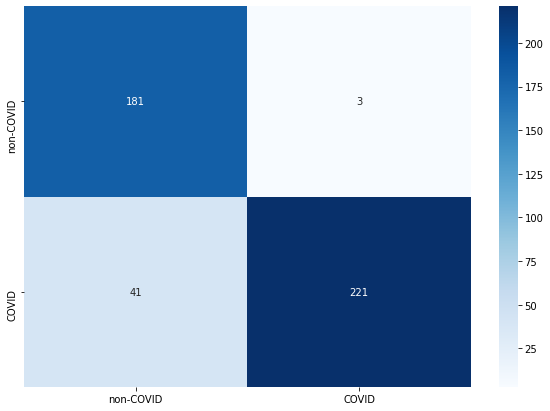

Epoch:4/10 AVG Training Loss:0.262 AVG Test Loss:0.199 AVG Training Acc 89.14 % AVG Test Acc 90.13 %


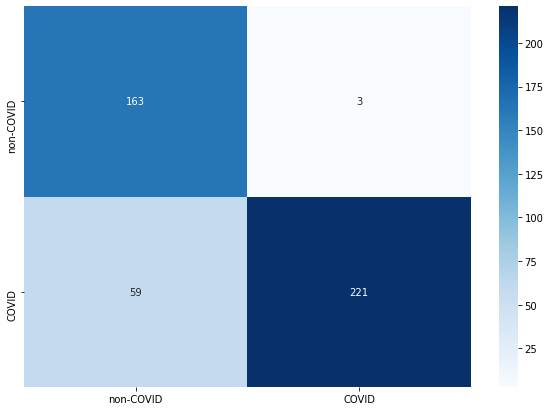

Epoch:5/10 AVG Training Loss:0.218 AVG Test Loss:0.299 AVG Training Acc 91.38 % AVG Test Acc 86.10 %


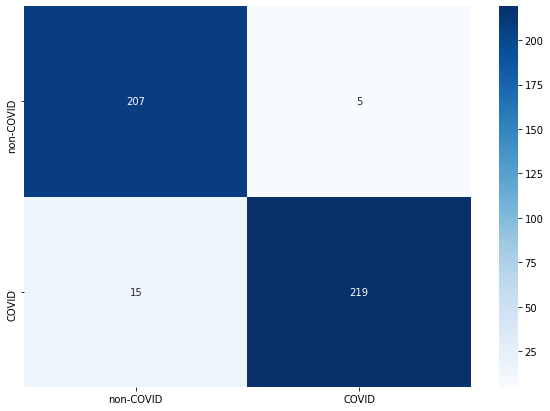

Epoch:6/10 AVG Training Loss:0.207 AVG Test Loss:0.133 AVG Training Acc 91.88 % AVG Test Acc 95.52 %


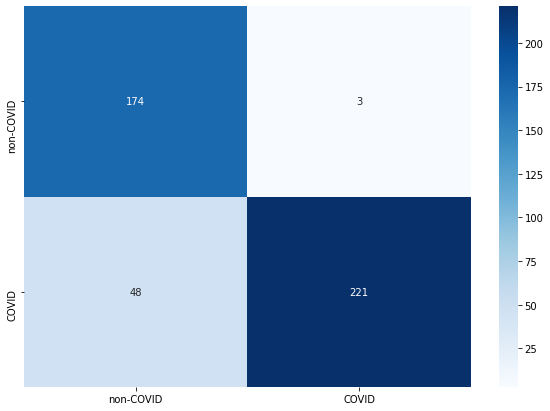

Epoch:7/10 AVG Training Loss:0.212 AVG Test Loss:0.231 AVG Training Acc 90.76 % AVG Test Acc 88.57 %


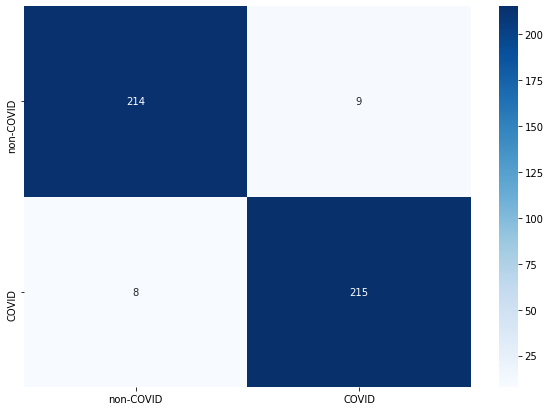

Epoch:8/10 AVG Training Loss:0.208 AVG Test Loss:0.127 AVG Training Acc 91.38 % AVG Test Acc 96.19 %


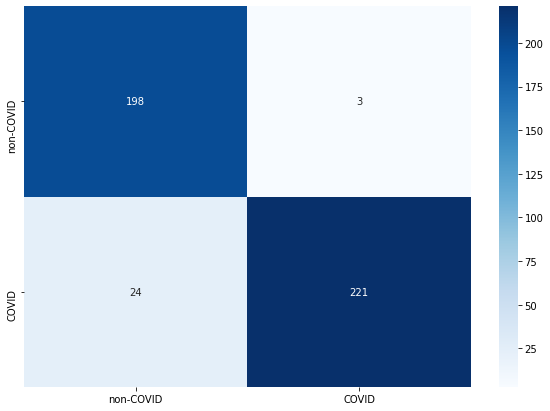

Epoch:9/10 AVG Training Loss:0.202 AVG Test Loss:0.150 AVG Training Acc 91.60 % AVG Test Acc 93.95 %


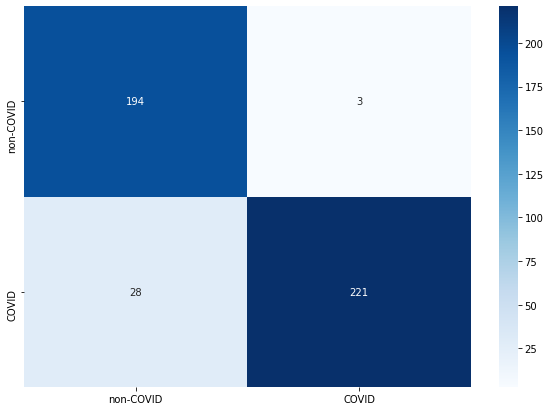

Epoch:10/10 AVG Training Loss:0.208 AVG Test Loss:0.154 AVG Training Acc 91.49 % AVG Test Acc 93.05 %
Fold 5
<function cross_entropy at 0x7f44f18c0f80>


  0%|          | 0/90 [00:00<?, ?it/s]

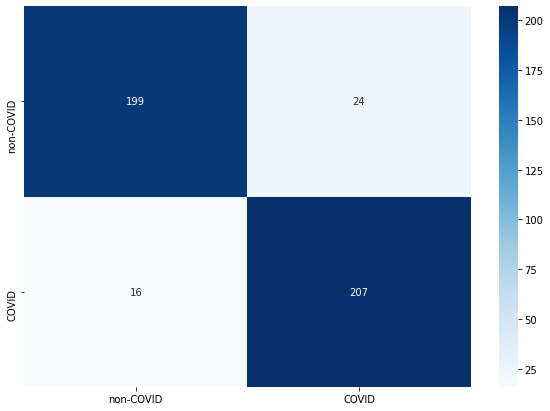

Epoch:1/10 AVG Training Loss:0.293 AVG Test Loss:0.188 AVG Training Acc 89.08 % AVG Test Acc 91.03 %


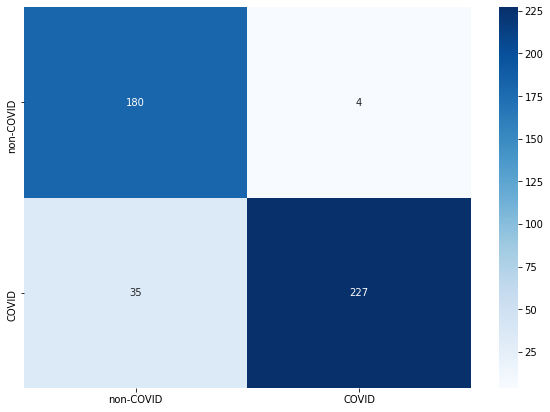

Epoch:2/10 AVG Training Loss:0.286 AVG Test Loss:0.263 AVG Training Acc 88.24 % AVG Test Acc 91.26 %


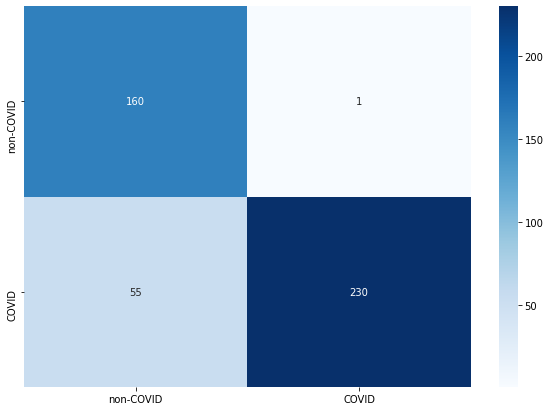

Epoch:3/10 AVG Training Loss:0.272 AVG Test Loss:0.377 AVG Training Acc 89.70 % AVG Test Acc 87.44 %


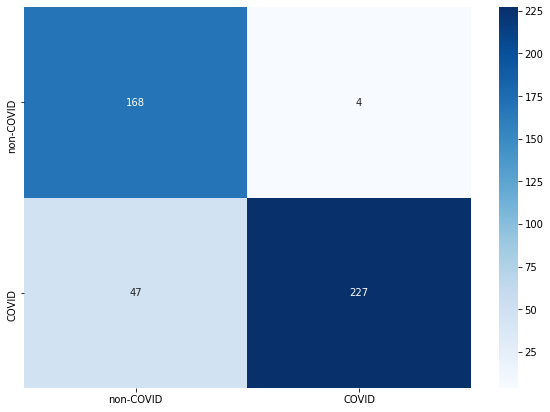

Epoch:4/10 AVG Training Loss:0.257 AVG Test Loss:0.326 AVG Training Acc 90.20 % AVG Test Acc 88.57 %


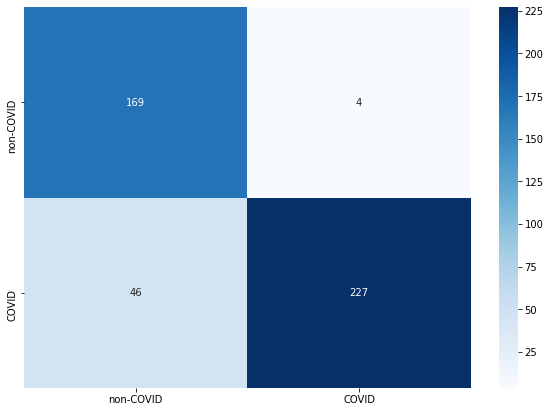

Epoch:5/10 AVG Training Loss:0.243 AVG Test Loss:0.340 AVG Training Acc 90.65 % AVG Test Acc 88.79 %


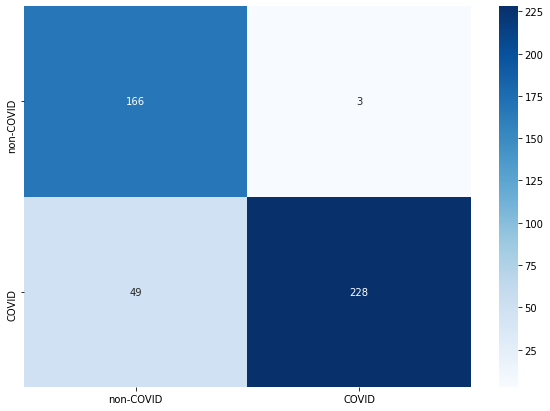

Epoch:6/10 AVG Training Loss:0.221 AVG Test Loss:0.345 AVG Training Acc 91.10 % AVG Test Acc 88.34 %


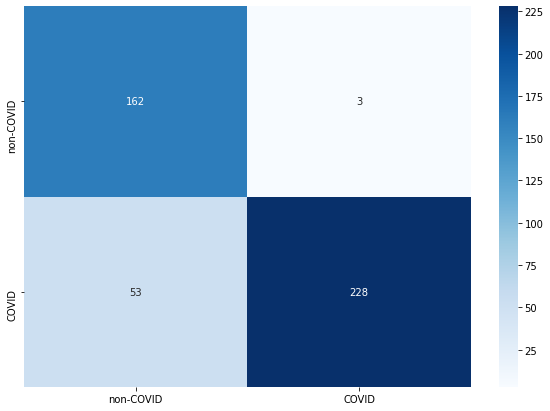

Epoch:7/10 AVG Training Loss:0.239 AVG Test Loss:0.378 AVG Training Acc 89.75 % AVG Test Acc 87.44 %


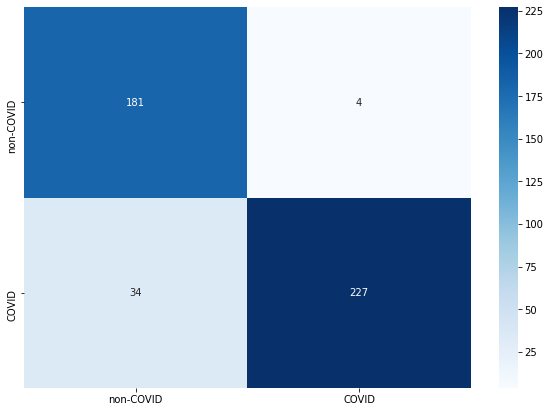

Epoch:8/10 AVG Training Loss:0.193 AVG Test Loss:0.274 AVG Training Acc 92.61 % AVG Test Acc 91.48 %


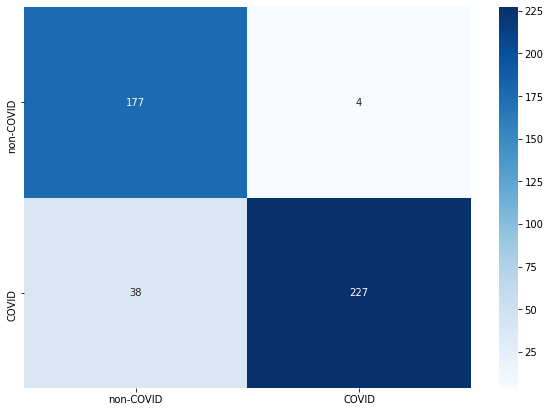

Epoch:9/10 AVG Training Loss:0.209 AVG Test Loss:0.293 AVG Training Acc 91.83 % AVG Test Acc 90.58 %


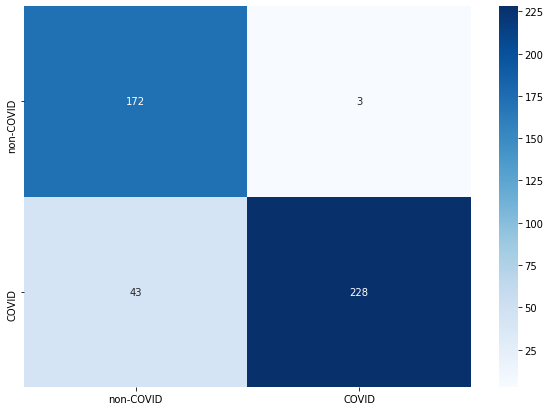

Epoch:10/10 AVG Training Loss:0.185 AVG Test Loss:0.311 AVG Training Acc 92.33 % AVG Test Acc 89.69 %


In [22]:
folderperf=cross_validate(model,num_classes,full_ds,opt_func,loss_func,grad_clip)

In [23]:
print("SQUEEZENET  With Freezing Cross Entropy+CV ")
cv_results(folderperf)

SQUEEZENET  With Freezing Cross Entropy+CV 
Performance of 5 fold cross validation
Average Training Loss: 0.277 	 Average val Loss: 0.289 	 Average Training Acc: 88.70 	 Average val Acc: 88.21
Max Training Acc: 92.61 	 Max val Acc: 96.19


In [24]:
def fold_plot(folderperf,num_rows,suptitle,num_cols=2):
  fig, axes = plt.subplots(num_rows, num_cols,figsize=(15, 15))
  fig.suptitle(suptitle,fontsize=16,y=1.02)
  for fold in range(1,num_rows+1):
    fold_results=folderperf['fold'+str(fold)]
    # 'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]
    train_loss=fold_results['train_loss']
    test_loss=fold_results['test_loss']
    train_acc=fold_results['train_acc']
    test_acc=fold_results['test_acc']
    axes[fold-1][0].plot(train_loss, label='train')
    axes[fold-1][0].plot(test_loss, label='validation')
    axes[fold-1][0].set_title("Train-Validation loss")
    axes[fold-1][0].set_xlabel('num_epochs', fontsize=12)
    axes[fold-1][0].set_ylabel('Loss', fontsize=12)
    axes[fold-1][0].legend(loc='best')

    axes[fold-1][1].plot(train_acc, label='train')
    axes[fold-1][1].plot(test_acc, label='validation')
    axes[fold-1][1].set_title("Train-Validation Acc")
    axes[fold-1][1].set_xlabel('num_epochs', fontsize=12)
    axes[fold-1][1].set_ylabel('Accuracy', fontsize=12)
    axes[fold-1][1].legend(loc='best')
  plt.tight_layout()
  plt.show()

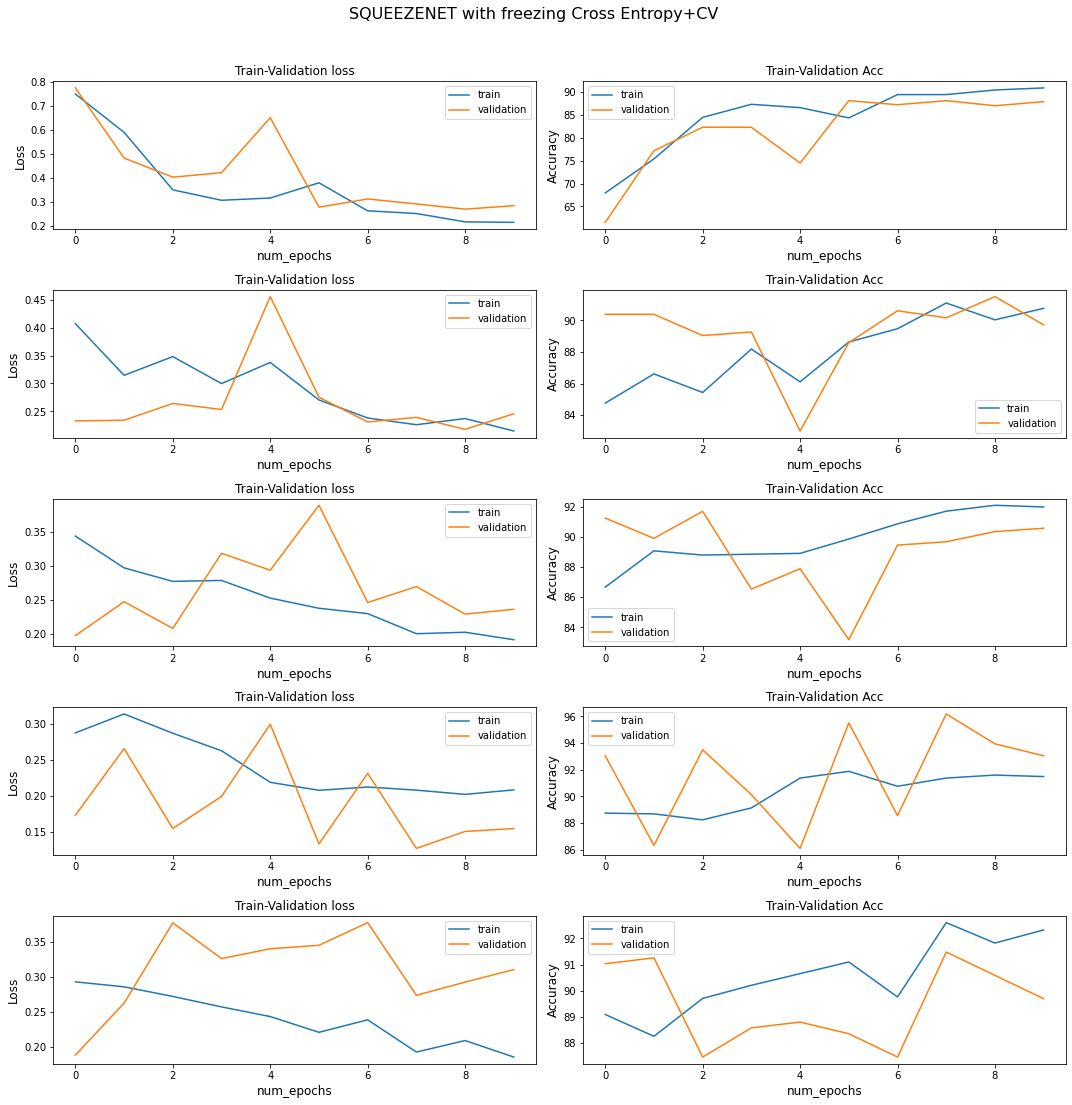

In [25]:
fold_plot(folderperf,k,"SQUEEZENET with freezing Cross Entropy+CV ")

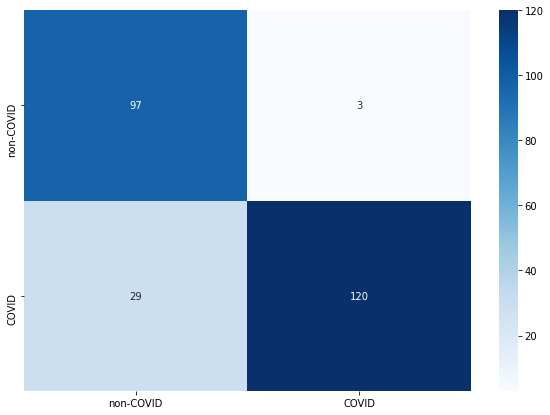

SQUEEZENET - with freezing + Cross Entropy + CV
Test Loss : 0.31 	 Test Accuracy : 87.15


In [26]:
# model,device,dataloader,test_dataset,loss_fn=F.cross_entropy,grad_clip=0
loss_func=F.cross_entropy
test_loss,test_acc=test(model,device,test_dl,test_ds,loss_func)
print("SQUEEZENET - with freezing + Cross Entropy + CV")
print("Test Loss : {:.2f} \t Test Accuracy : {:.2f}".format(test_loss,test_acc))

### Focal Loss

In [27]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [28]:
# Parameters
num_classes=2
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss_func=F.cross_entropy
gamma=2
alpha=0.25
k=5



In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_func=FocalLoss(gamma=gamma,alpha=alpha)
splits=KFold(n_splits=k,shuffle=True,random_state=42)

In [30]:
model=SQUEEZENET(num_classes)
to_device(model,device)

SQUEEZENET(
  (network): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (exp

Fold 1
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


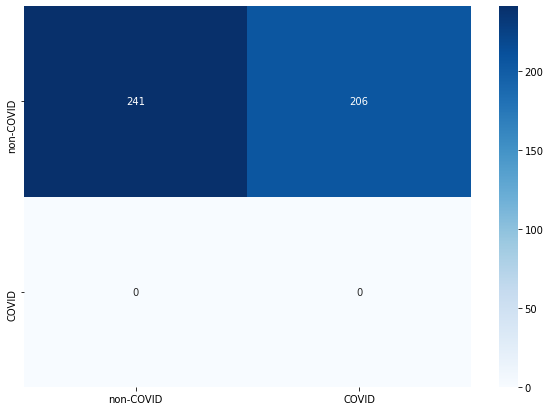

Epoch:1/10 AVG Training Loss:0.100 AVG Test Loss:0.083 AVG Training Acc 50.08 % AVG Test Acc 53.91 %


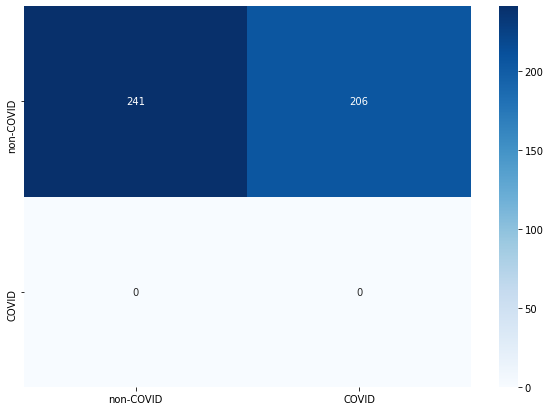

Epoch:2/10 AVG Training Loss:0.087 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


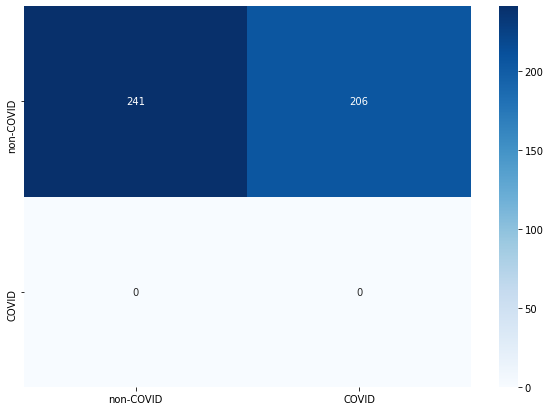

Epoch:3/10 AVG Training Loss:0.087 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


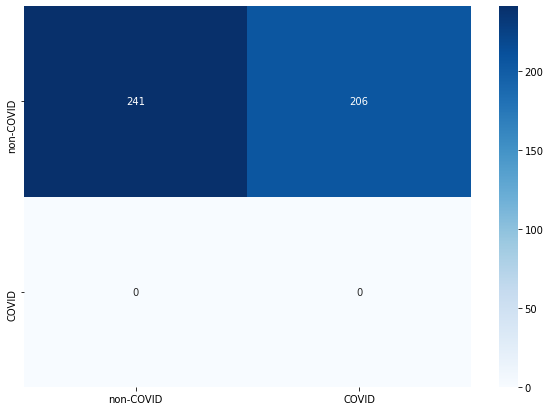

Epoch:4/10 AVG Training Loss:0.087 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


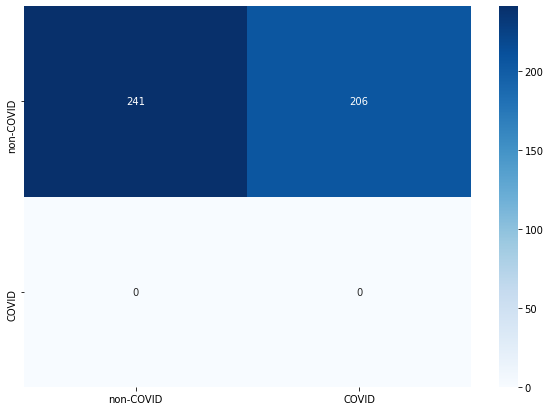

Epoch:5/10 AVG Training Loss:0.086 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


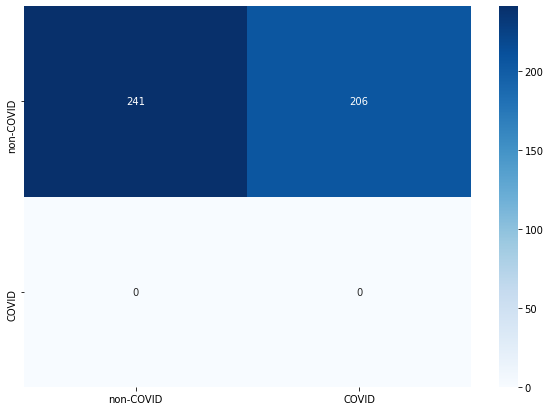

Epoch:6/10 AVG Training Loss:0.085 AVG Test Loss:0.082 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


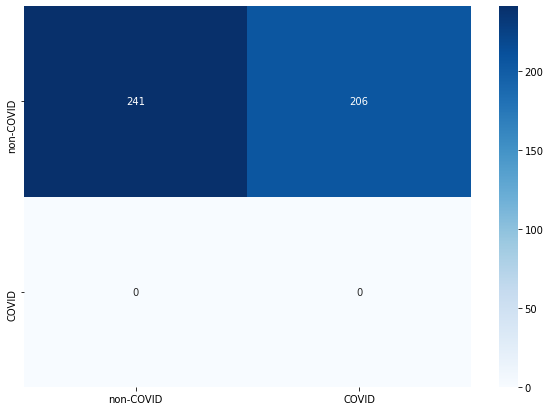

Epoch:7/10 AVG Training Loss:0.083 AVG Test Loss:0.079 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


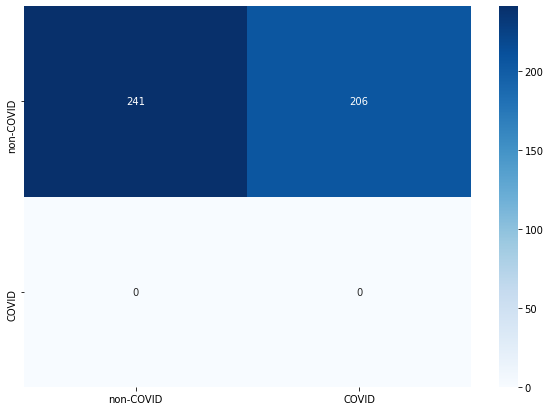

Epoch:8/10 AVG Training Loss:0.082 AVG Test Loss:0.079 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


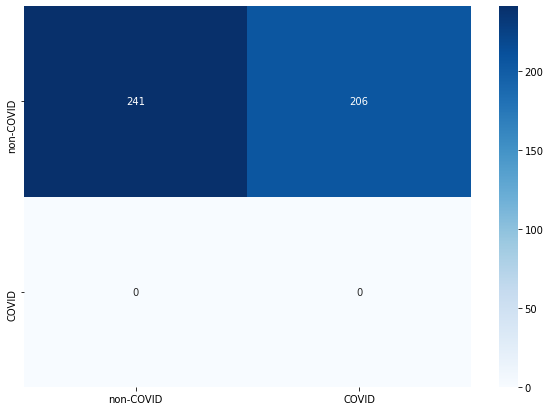

Epoch:9/10 AVG Training Loss:0.081 AVG Test Loss:0.078 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


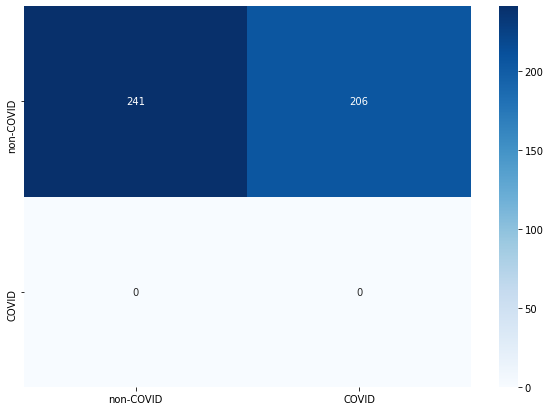

Epoch:10/10 AVG Training Loss:0.081 AVG Test Loss:0.078 AVG Training Acc 49.58 % AVG Test Acc 53.91 %
Fold 2
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

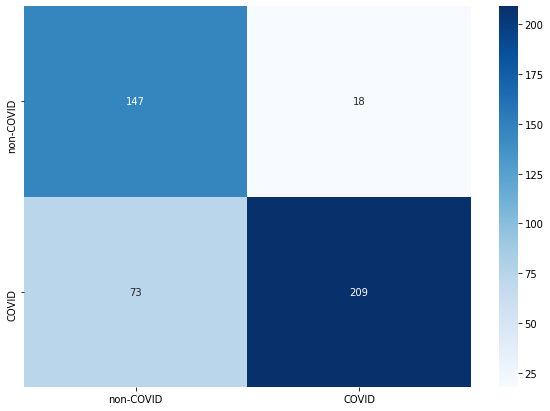

Epoch:1/10 AVG Training Loss:0.056 AVG Test Loss:0.063 AVG Training Acc 70.98 % AVG Test Acc 79.64 %


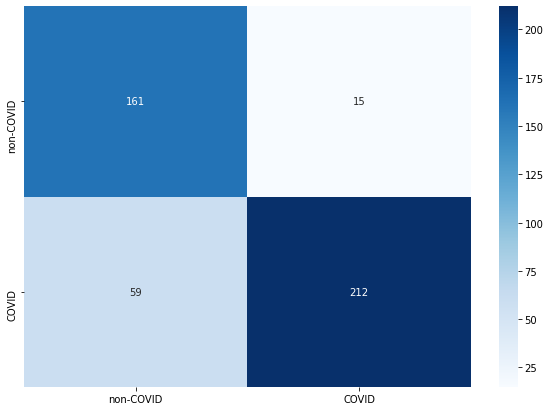

Epoch:2/10 AVG Training Loss:0.044 AVG Test Loss:0.061 AVG Training Acc 76.64 % AVG Test Acc 83.45 %


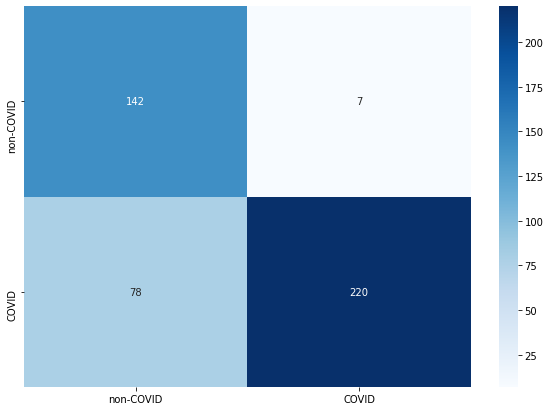

Epoch:3/10 AVG Training Loss:0.042 AVG Test Loss:0.041 AVG Training Acc 78.66 % AVG Test Acc 80.98 %


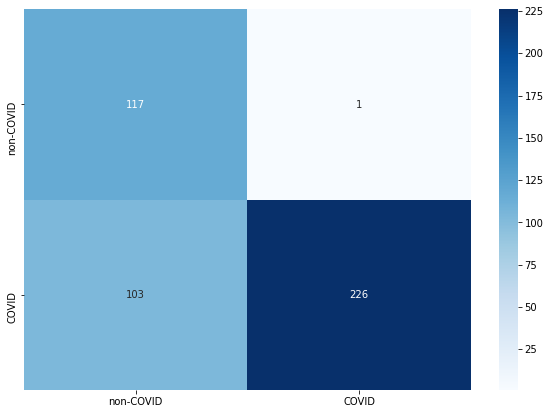

Epoch:4/10 AVG Training Loss:0.039 AVG Test Loss:0.046 AVG Training Acc 80.22 % AVG Test Acc 76.73 %


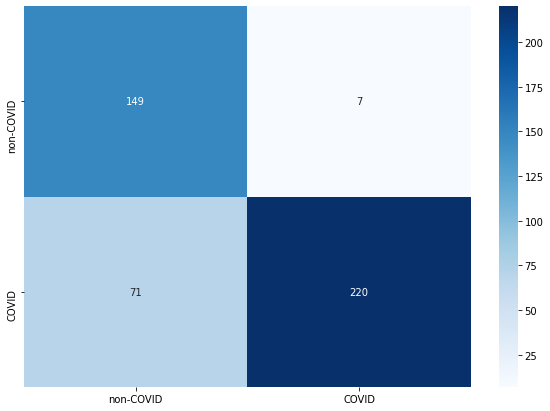

Epoch:5/10 AVG Training Loss:0.036 AVG Test Loss:0.053 AVG Training Acc 81.06 % AVG Test Acc 82.55 %


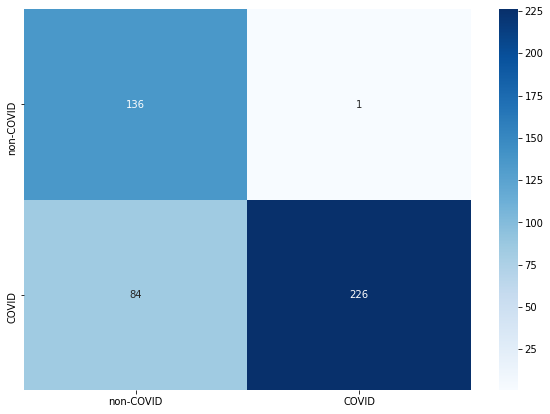

Epoch:6/10 AVG Training Loss:0.036 AVG Test Loss:0.032 AVG Training Acc 82.58 % AVG Test Acc 80.98 %


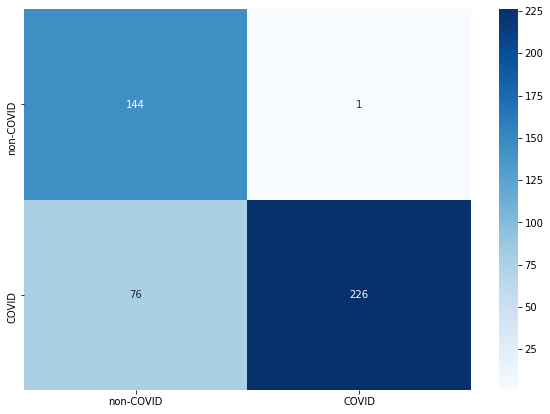

Epoch:7/10 AVG Training Loss:0.035 AVG Test Loss:0.040 AVG Training Acc 83.25 % AVG Test Acc 82.77 %


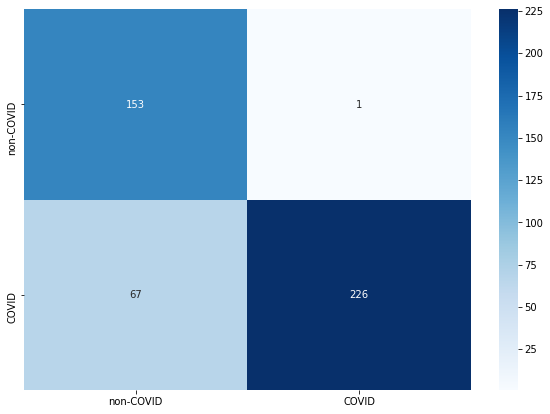

Epoch:8/10 AVG Training Loss:0.033 AVG Test Loss:0.038 AVG Training Acc 83.70 % AVG Test Acc 84.79 %


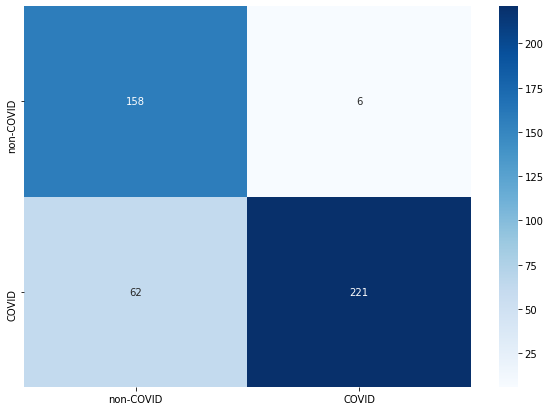

Epoch:9/10 AVG Training Loss:0.031 AVG Test Loss:0.035 AVG Training Acc 83.81 % AVG Test Acc 84.79 %


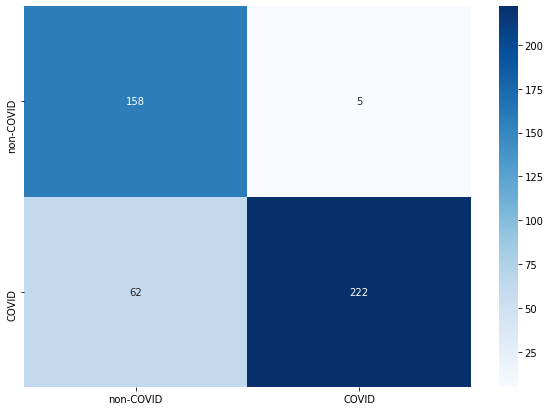

Epoch:10/10 AVG Training Loss:0.031 AVG Test Loss:0.034 AVG Training Acc 84.76 % AVG Test Acc 85.01 %
Fold 3
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

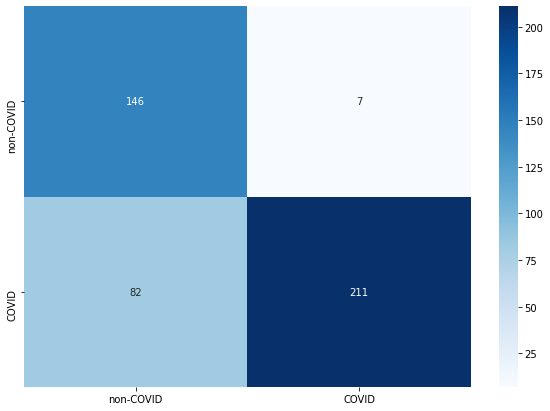

Epoch:1/10 AVG Training Loss:0.041 AVG Test Loss:0.049 AVG Training Acc 80.18 % AVG Test Acc 80.04 %


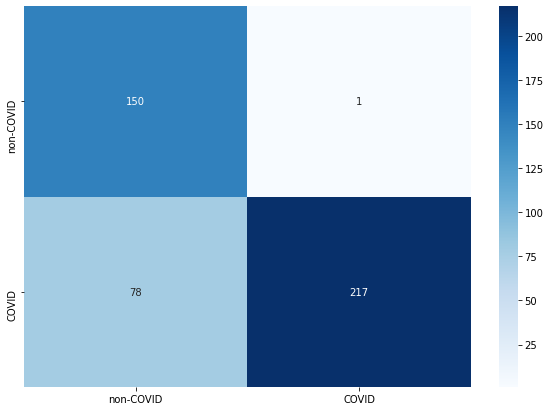

Epoch:2/10 AVG Training Loss:0.039 AVG Test Loss:0.037 AVG Training Acc 80.07 % AVG Test Acc 82.29 %


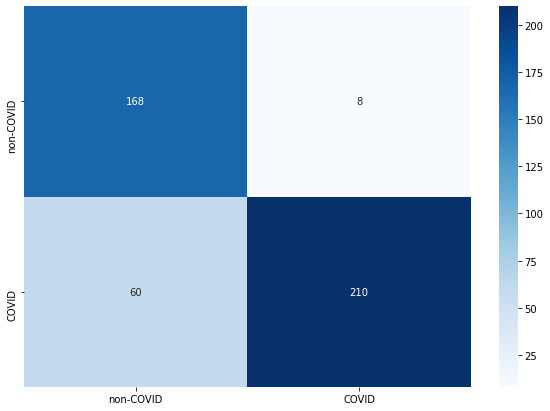

Epoch:3/10 AVG Training Loss:0.036 AVG Test Loss:0.036 AVG Training Acc 81.24 % AVG Test Acc 84.75 %


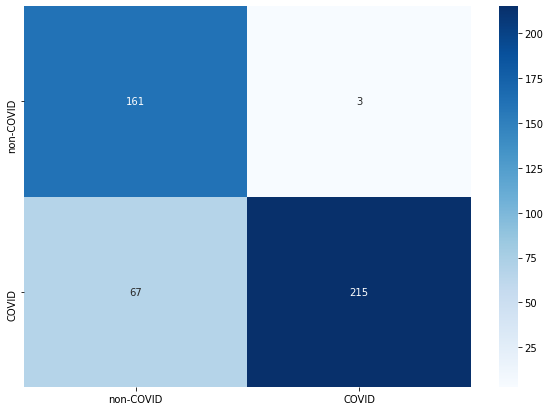

Epoch:4/10 AVG Training Loss:0.034 AVG Test Loss:0.036 AVG Training Acc 83.31 % AVG Test Acc 84.30 %


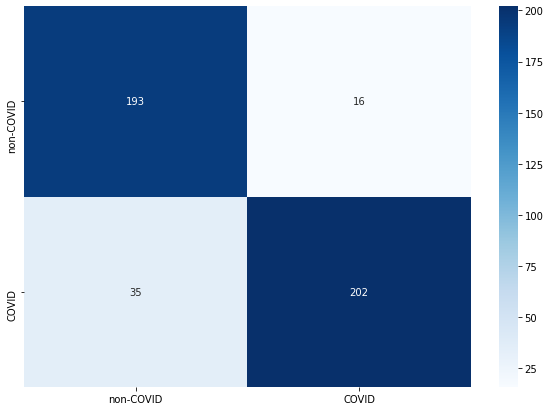

Epoch:5/10 AVG Training Loss:0.034 AVG Test Loss:0.039 AVG Training Acc 83.54 % AVG Test Acc 88.57 %


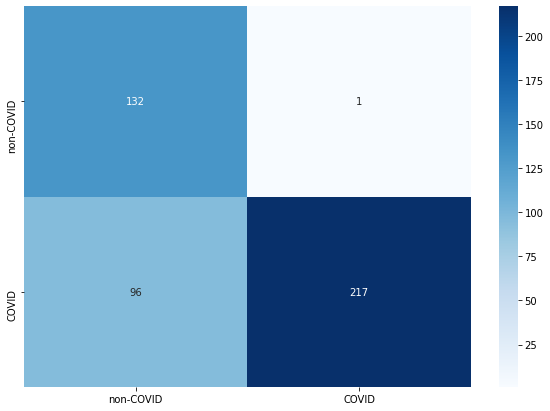

Epoch:6/10 AVG Training Loss:0.032 AVG Test Loss:0.032 AVG Training Acc 85.11 % AVG Test Acc 78.25 %


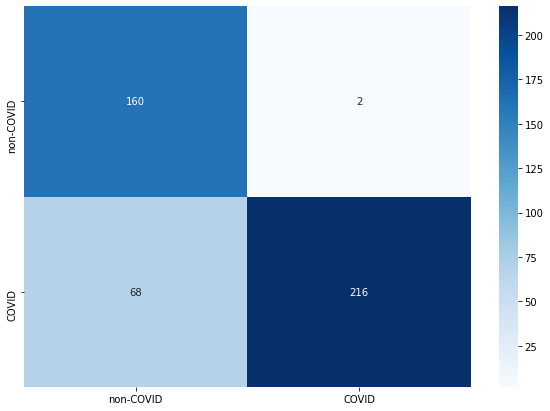

Epoch:7/10 AVG Training Loss:0.035 AVG Test Loss:0.034 AVG Training Acc 82.98 % AVG Test Acc 84.30 %


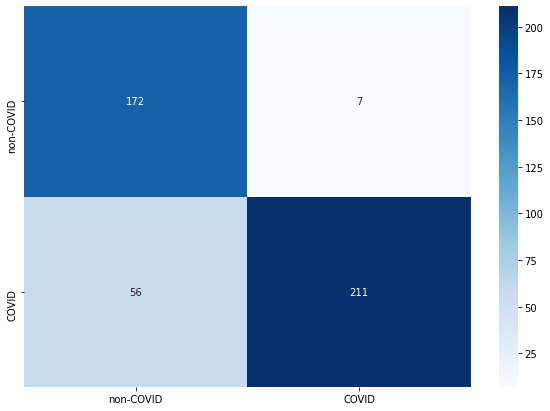

Epoch:8/10 AVG Training Loss:0.030 AVG Test Loss:0.033 AVG Training Acc 85.89 % AVG Test Acc 85.87 %


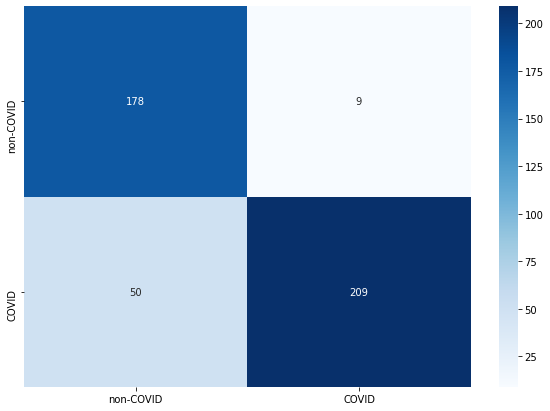

Epoch:9/10 AVG Training Loss:0.028 AVG Test Loss:0.033 AVG Training Acc 87.07 % AVG Test Acc 86.77 %


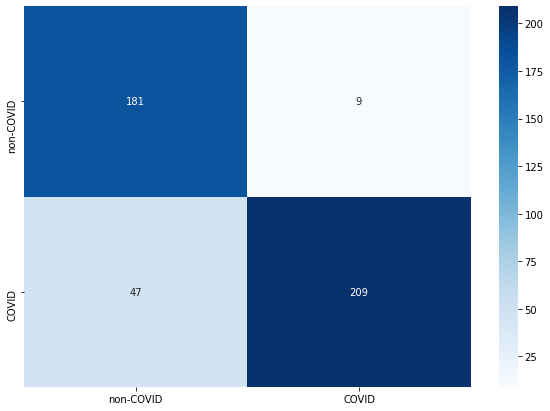

Epoch:10/10 AVG Training Loss:0.028 AVG Test Loss:0.033 AVG Training Acc 87.29 % AVG Test Acc 87.44 %
Fold 4
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

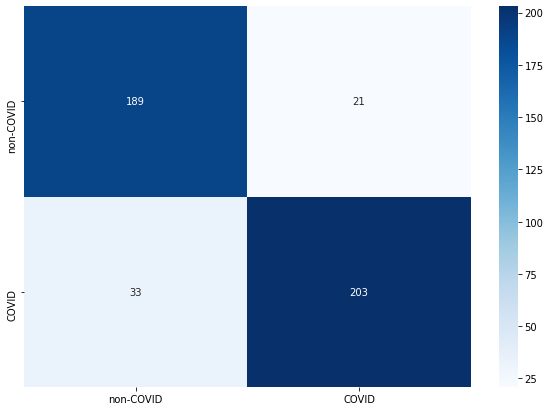

Epoch:1/10 AVG Training Loss:0.038 AVG Test Loss:0.044 AVG Training Acc 82.03 % AVG Test Acc 87.89 %


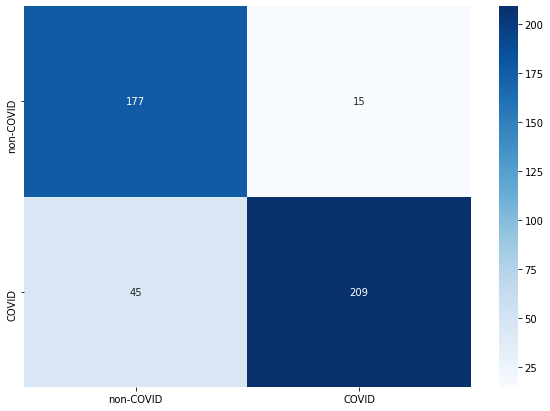

Epoch:2/10 AVG Training Loss:0.036 AVG Test Loss:0.047 AVG Training Acc 82.98 % AVG Test Acc 86.55 %


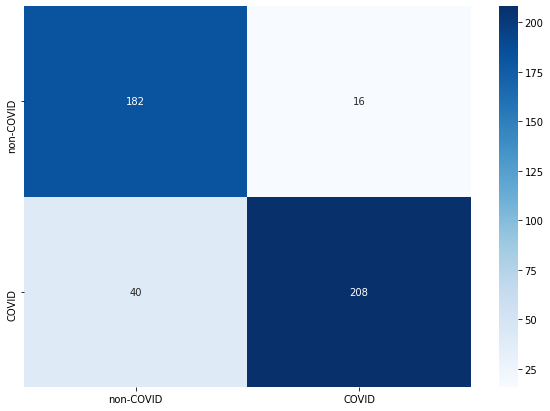

Epoch:3/10 AVG Training Loss:0.035 AVG Test Loss:0.043 AVG Training Acc 82.81 % AVG Test Acc 87.44 %


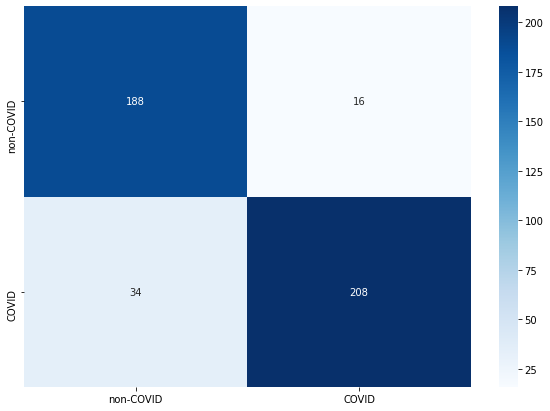

Epoch:4/10 AVG Training Loss:0.032 AVG Test Loss:0.041 AVG Training Acc 84.77 % AVG Test Acc 88.79 %


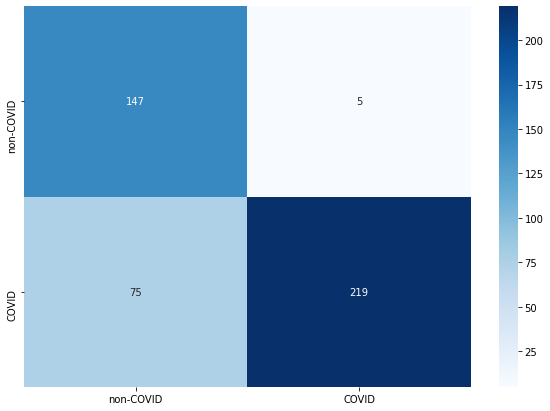

Epoch:5/10 AVG Training Loss:0.033 AVG Test Loss:0.035 AVG Training Acc 84.60 % AVG Test Acc 82.06 %


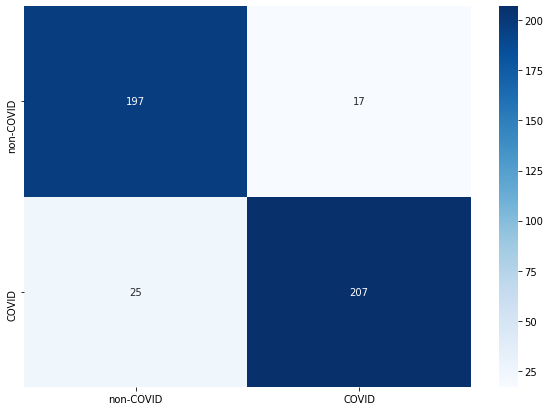

Epoch:6/10 AVG Training Loss:0.032 AVG Test Loss:0.040 AVG Training Acc 85.83 % AVG Test Acc 90.58 %


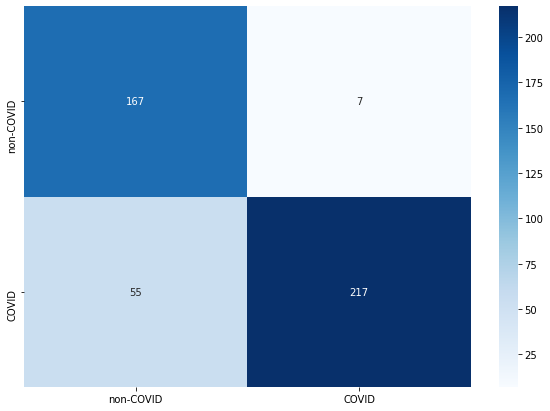

Epoch:7/10 AVG Training Loss:0.028 AVG Test Loss:0.032 AVG Training Acc 86.28 % AVG Test Acc 86.10 %


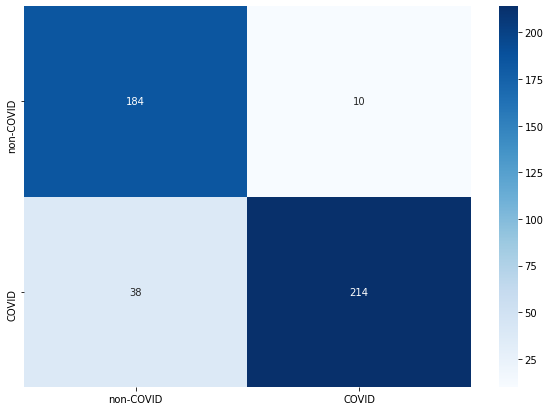

Epoch:8/10 AVG Training Loss:0.028 AVG Test Loss:0.037 AVG Training Acc 87.68 % AVG Test Acc 89.24 %


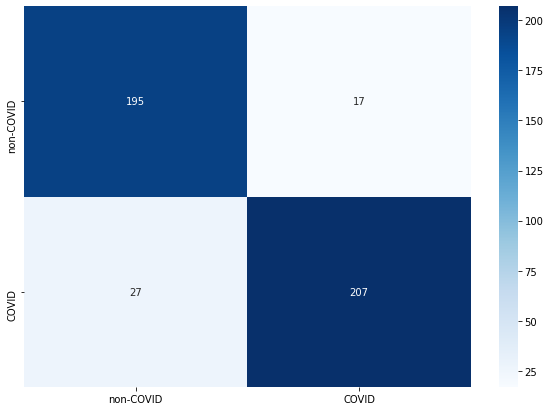

Epoch:9/10 AVG Training Loss:0.026 AVG Test Loss:0.040 AVG Training Acc 88.35 % AVG Test Acc 90.13 %


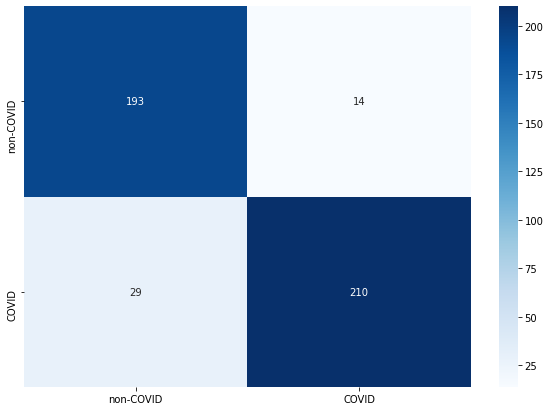

Epoch:10/10 AVG Training Loss:0.027 AVG Test Loss:0.037 AVG Training Acc 87.51 % AVG Test Acc 90.36 %
Fold 5
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

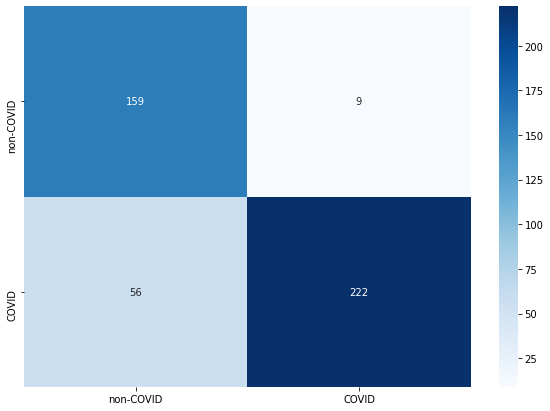

Epoch:1/10 AVG Training Loss:0.037 AVG Test Loss:0.040 AVG Training Acc 82.59 % AVG Test Acc 85.43 %


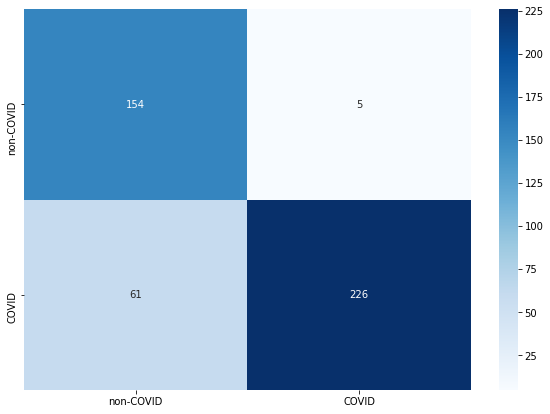

Epoch:2/10 AVG Training Loss:0.032 AVG Test Loss:0.038 AVG Training Acc 84.77 % AVG Test Acc 85.20 %


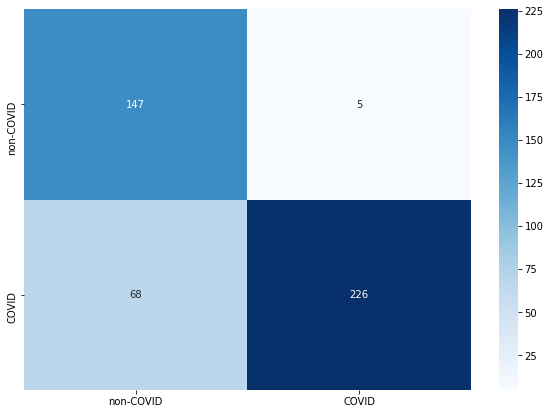

Epoch:3/10 AVG Training Loss:0.032 AVG Test Loss:0.034 AVG Training Acc 85.50 % AVG Test Acc 83.63 %


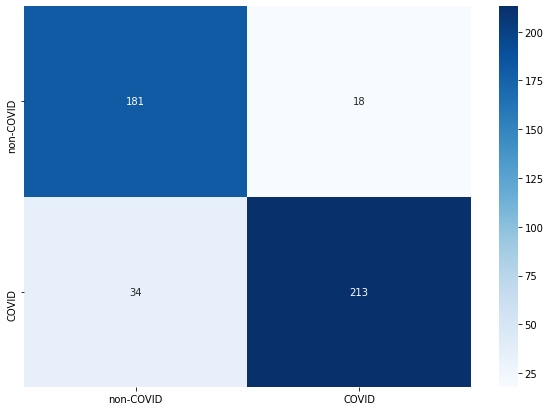

Epoch:4/10 AVG Training Loss:0.030 AVG Test Loss:0.037 AVG Training Acc 86.06 % AVG Test Acc 88.34 %


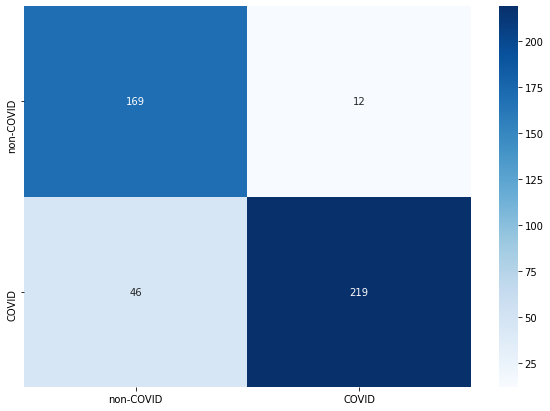

Epoch:5/10 AVG Training Loss:0.031 AVG Test Loss:0.037 AVG Training Acc 85.44 % AVG Test Acc 87.00 %


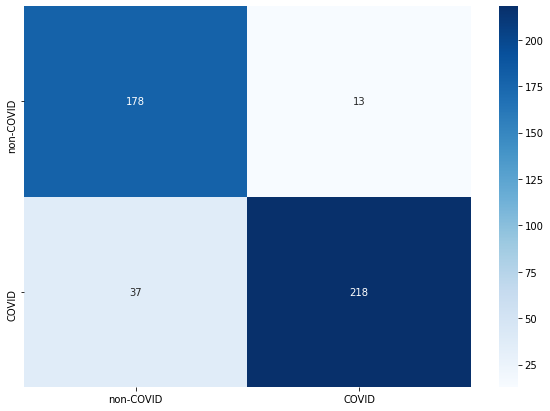

Epoch:6/10 AVG Training Loss:0.030 AVG Test Loss:0.038 AVG Training Acc 86.95 % AVG Test Acc 88.79 %


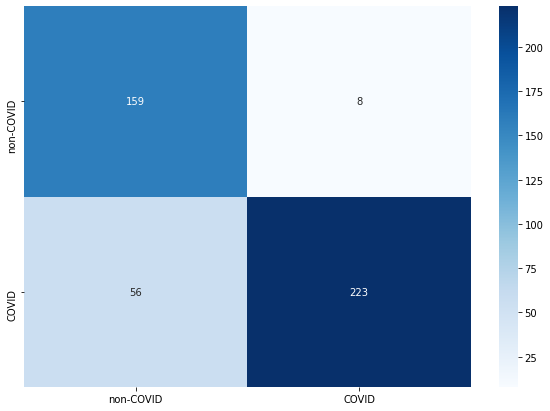

Epoch:7/10 AVG Training Loss:0.027 AVG Test Loss:0.036 AVG Training Acc 88.24 % AVG Test Acc 85.65 %


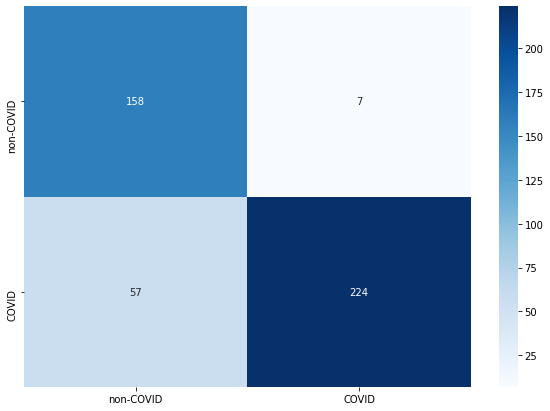

Epoch:8/10 AVG Training Loss:0.026 AVG Test Loss:0.034 AVG Training Acc 87.85 % AVG Test Acc 85.65 %


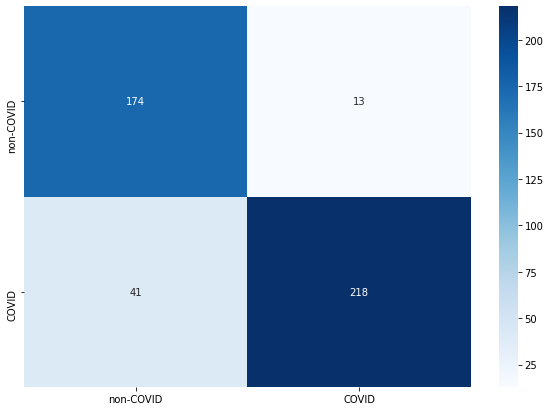

Epoch:9/10 AVG Training Loss:0.026 AVG Test Loss:0.036 AVG Training Acc 87.35 % AVG Test Acc 87.89 %


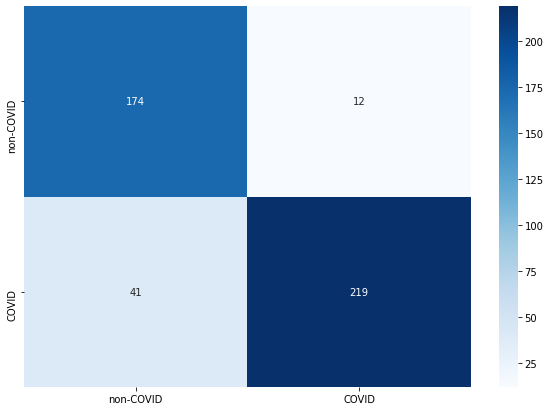

Epoch:10/10 AVG Training Loss:0.026 AVG Test Loss:0.036 AVG Training Acc 87.79 % AVG Test Acc 88.12 %


In [31]:
folderperf=cross_validate(model,num_classes,full_ds,opt_func,loss_func,grad_clip)

In [32]:
print("SQUEEZENET  With Freezing Focal Loss+CV ")
cv_results(folderperf)

SQUEEZENET  With Freezing Focal Loss+CV 
Performance of 5 fold cross validation
Average Training Loss: 0.044 	 Average val Loss: 0.048 	 Average Training Acc: 77.08 	 Average val Acc: 78.97
Max Training Acc: 88.35 	 Max val Acc: 90.58


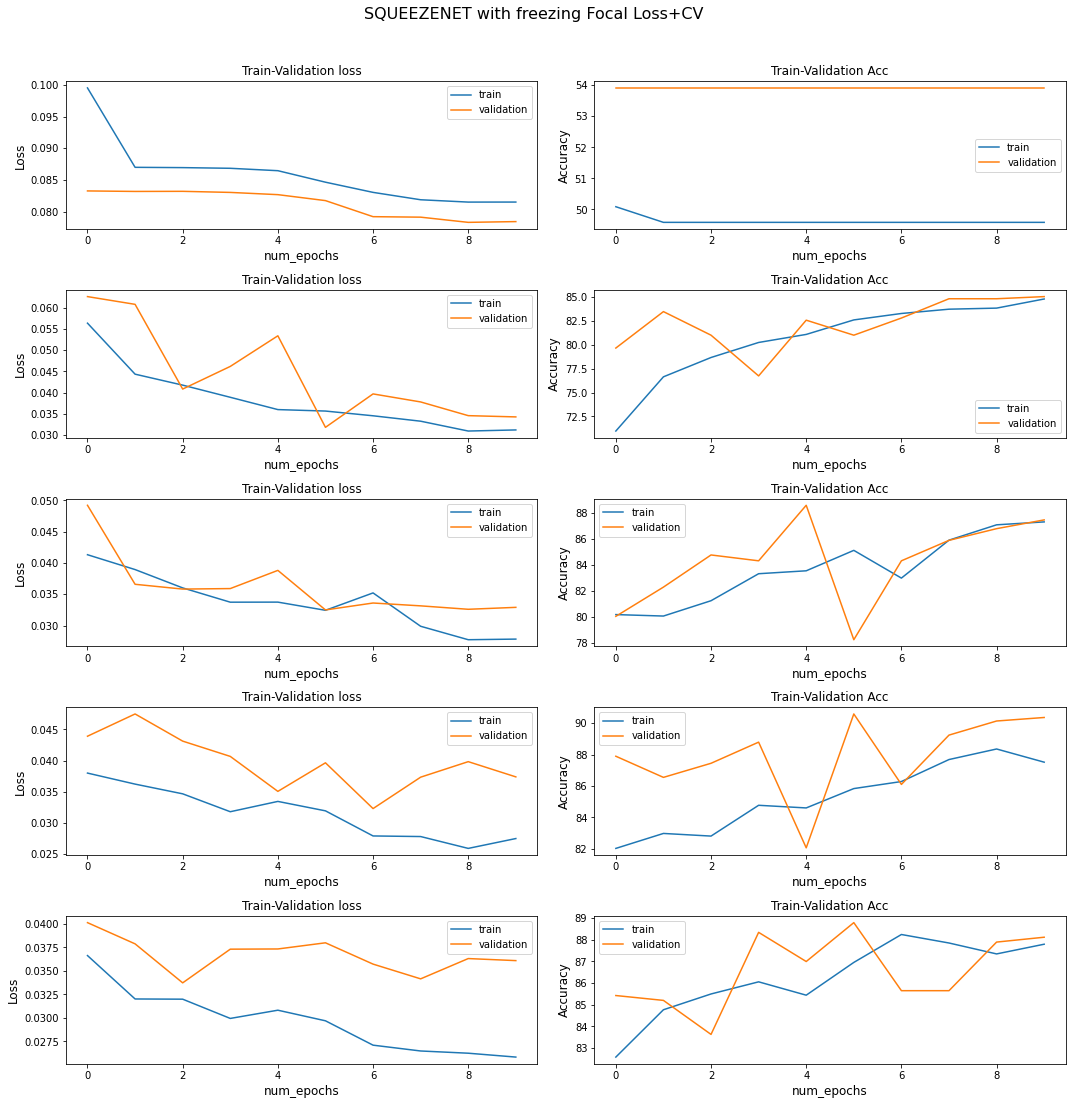

In [33]:
fold_plot(folderperf,k,"SQUEEZENET with freezing Focal Loss+CV ")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


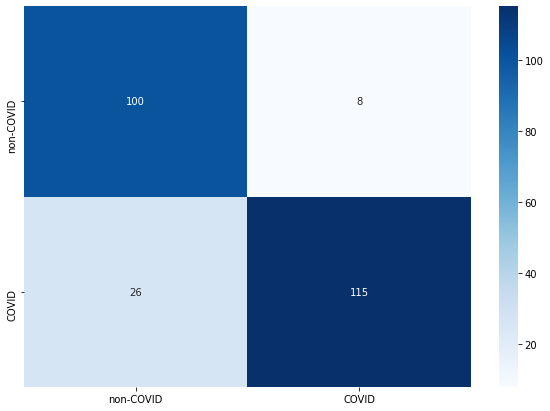

SQUEEZENET - with freezing + focal loss + CV
Test Loss : 0.04 	 Test Accuracy : 86.35


In [34]:
# model,device,dataloader,test_dataset,loss_fn=F.cross_entropy,grad_clip=0
loss_func=FocalLoss(gamma=gamma,alpha=alpha)
test_loss,test_acc=test(model,device,test_dl,test_ds,loss_func)
print("SQUEEZENET - with freezing + focal loss + CV")
print("Test Loss : {:.2f} \t Test Accuracy : {:.2f}".format(test_loss,test_acc))